# Анализ медицинских организаций по Твери и Тверской области



Заказчик хочет получить систему, которая поможет оценить уровень укомплектованности медицинских организаций в городе Твери и Тверской области. Он предоставил нам документ с данными о самих организациях и обезличенной информацией о сотрудниках.

Наша задача — ответить на несколько важных вопросов:

- Оценить, насколько остро стоит проблема нехватки квалифицированных кадров в Тверской области.
- Проанализировать, как обстоят дела с оказанием первичной врачебной медико-санитарной помощи в разрезе возрастных групп.
- Сравнить, как распределяется гендерный состав среди сотрудников разных возрастов.

# Чтение данных

Помимо предоставленных данных от заказчика, нам повезло получить файл в формате GPKG (GeoPackage) с информацией о полигонах муниципалитетов Тверской области. Рассмотрим, какие данные хранятся в данных.

In [1]:
#импортируем библиотеки для работы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon, Polygon
from google.colab import files
import geopandas as gpd
from haversine import haversine, Unit

import warnings
#устанавливаем единый стиль для графиков
palette=['#56bec7','#2982a5','#014a84','#474477','#3b637d','#498776','#7fb15b','#6ab891']
sns.set_palette(palette)
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

#выводим все стоблцы в таблицах
pd.set_option('display.max_columns', None)

In [2]:
#функция для первичного изучения датасета
def show_info(df, whole=True):
    if whole:
        display(df.info())
        print('-' * 25)
        print('Проверка на дубликаты:', df.duplicated().sum())
        print('-' * 25)
        print('Проверка на пропуски')
        display(df.isnull().sum())
        print('-' * 25)
        print('Статистика')
        display(df.describe(include=['object']).T)
        if not df.select_dtypes(include=['int64', 'float64']).empty:
            display(df.select_dtypes(include=['int64', 'float64']).describe().T)
        print('-' * 25)
        display(df.head())
    else:
        display(df.info())
        print('-' * 25)
        display(df.describe(include=['object']).T)
        if not df.select_dtypes(include=['int64', 'float64']).empty:
            display(df.select_dtypes(include=['int64', 'float64']).describe().T)
        print('-' * 25)
        display(df.head())

In [3]:
#считываем данные по каждой вкладке
coord, staff = (pd.read_csv("https://docs.google.com/spreadsheets/d/1ud_Tc2aS/gviz/tq?tqx=out:csv&gid=274012820"),
             pd.read_csv("https://docs.google.com/spreadsheets/d/1ud_Tc2aS/gviz/tq?tqx=out:csv&gid=1027350161"))

In [4]:
#подгружаем данные о полигонах
uploaded = files.upload()
#считываем данные
polygons = gpd.read_file('tver.gpkg')

Saving tver.gpkg to tver.gpkg


In [5]:
#выведем информацию об организациях
show_info(coord)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Организация по основной должности  113 non-null    object
 1   Сокращенное название организации   113 non-null    object
 2   Округ/район                        113 non-null    object
 3   Адрес                              113 non-null    object
 4   Координаты                         113 non-null    object
dtypes: object(5)
memory usage: 4.5+ KB


None

-------------------------
Проверка на дубликаты: 0
-------------------------
Проверка на пропуски


,0
Организация по основной должности,0
Сокращенное название организации,0
Округ/район,0
Адрес,0
Координаты,0


-------------------------
Статистика


,count,unique,top,freq
Организация по основной должности,113,113,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ...,1
Сокращенное название организации,113,113,"АНО ""БЕЛАЯ РОЗА""",1
Округ/район,113,38,городской округ город Тверь,59
Адрес,113,111,"170026, Тверская область, город Тверь, Комсомо...",2
Координаты,113,112,"56.85261396057918, 35.8811559111127",2


-------------------------


,Организация по основной должности,Сокращенное название организации,Округ/район,Адрес,Координаты
0,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ...,"АНО ""БЕЛАЯ РОЗА""",городской округ город Тверь,"170100, Тверская область, город Тверь, Тверско...","56.86053266726136, 35.909560612319325"
1,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""КОНАКОВСКИЙ ЗАВОД СТАЛЬН...","АО ""КЗСК""",Конаковский район,"171252, Тверская область, г. Конаково, ул. Про...","56.72231762064035, 36.78252888653642"
2,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,"ГБУЗ ""КАШИНСКАЯ СП""",Кашинский городской округ,"Тверская область, г. Кашин, ул. Карла Маркса, ...","57.355114792071056, 37.6091387505305"
3,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,"ГБУЗ ""КАШИНСКАЯ ЦРБ""",Кашинский городской округ,"171640, Тверская область, г. Кашин, ул. Вонжин...","57.35759162268202, 37.622431951037704"
4,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,"ГБУЗ ""КИМРСКАЯ ЦРБ""",городской округ город Кимры,"171502, Тверская область, г. Кимры, Борковское...","56.83610336308383, 37.36593272292891"


- Нам предстоит рассмотреть 113 медицинских учреждений.
- В информации о них нет пропусков и полных дубликатов.
- В датасете есть информация о 38 округах или районах.
- Большая часть медицинских учреждений датасета находится в городе Тверь.
- Адрес и координаты дважды повторяются при отсутствии полных дубликатов.

In [6]:
#выведем информацию о сотрудниках
show_info(staff)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Unnamed: 0                         1419 non-null   int64 
 1   Дата рождения                      1419 non-null   object
 2   Возраст                            1419 non-null   int64 
 3   Пол                                1419 non-null   object
 4   Организация по основной должности  1414 non-null   object
 5   Основная должность                 1414 non-null   object
dtypes: int64(2), object(4)
memory usage: 66.6+ KB


None

-------------------------
Проверка на дубликаты: 0
-------------------------
Проверка на пропуски


,0
Unnamed: 0,0
Дата рождения,0
Возраст,0
Пол,0
Организация по основной должности,5
Основная должность,5


-------------------------
Статистика


,count,unique,top,freq
Дата рождения,1419,1350,15.03.1994,3
Пол,1419,2,Жен.,984
Организация по основной должности,1414,113,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,105
Основная должность,1414,14,рентгенолаборант,166


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1419.0,710.000000,409.774328,1.0,355.5,710.0,1064.5,1419.0
Возраст,1419.0,45.766032,15.175381,21.0,31.0,44.0,59.0,86.0


-------------------------


,Unnamed: 0,Дата рождения,Возраст,Пол,Организация по основной должности,Основная должность
0,1,01.01.1958,66,Муж.,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,Врач-анестезиолог-реаниматолог
1,2,13.11.1968,55,Жен.,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,Рентгенолаборант
2,3,01.02.1950,74,Муж.,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,Врач общей практики (семейный врач)
3,4,08.02.1957,67,Муж.,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,Врач-анестезиолог-реаниматолог
4,5,14.11.1974,49,Жен.,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,врач общей практики (семейный врач)


- У нас есть информация о 1419 сотрудниках медицинских учреждений.
- Полных дубликатов о сотрудниках нет.
- У пяти из них отсутствует информация о должности и организации.
- Дата рождения указана в текстовом формате.
- Женщин в датасете больше, чем мужчин.
- Количество медицинских организаций совпадает с количеством из первой таблицы.
- Среди имеющихся специалистов преобладают рентгенолаборанты.
- Наименования должности имеют написание с заглавной и со строчной буквы.
- Есть столбец, не несущий смысловой нагрузки: `Unnamed: 0`.

In [7]:
#выведем информацию о полигонах
show_info(polygons)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 24 columns):
 #   Column                                                             Non-Null Count  Dtype   
---  ------                                                             --------------  -----   
 0   osm_ref                                                            46 non-null     object  
 1   osm_vers                                                           46 non-null     object  
 2   territory_id                                                       46 non-null     object  
 3   year_from                                                          46 non-null     int64   
 4   year_to                                                            46 non-null     int64   
 5   t_dict_municipal_districts — Sheet1_municipal_district_name_short  46 non-null     object  
 6   t_dict_municipal_districts — Sheet1_oktmo                          46 non-null     object  
 7   t_dict_muni

None

-------------------------
Проверка на дубликаты: 0
-------------------------
Проверка на пропуски


,0
osm_ref,0
osm_vers,0
territory_id,0
year_from,0
year_to,0
t_dict_municipal_districts — Sheet1_municipal_district_name_short,0
t_dict_municipal_districts — Sheet1_oktmo,0
t_dict_municipal_districts — Sheet1_municipal_district_name,0
t_dict_municipal_districts — Sheet1_municipal_district_type,0
t_dict_municipal_districts — Sheet1_municipal_district_status,43


-------------------------
Статистика


,count,unique,top,freq
osm_ref,46,43,570646,2
osm_vers,46,7,2023-01-01T01:00:00Z,38
territory_id,46,46,2102,1
t_dict_municipal_districts — Sheet1_municipal_district_name_short,46,43,Кимрский,2
t_dict_municipal_districts — Sheet1_oktmo,46,45,28-714-000-000,2
t_dict_municipal_districts — Sheet1_municipal_district_name,46,46,городской округ город Вышний Волочек,1
t_dict_municipal_districts — Sheet1_municipal_district_type,46,3,муниципальный округ,30
t_dict_municipal_districts — Sheet1_municipal_district_status,3,2,ЗАТО,2
t_dict_municipal_districts — Sheet1_shape_linked_oktmo,10,10,28-612-000-000,1
t_dict_municipal_districts — Sheet1_municipal_district_center,46,38,г Вышний Волочек,3


,count,mean,std,min,25%,50%,75%,max
year_from,46.0,2018.260870,1.063219,2018.000000,2018.000000,2018.000000,2018.000000,2023.000000
year_to,46.0,8958.521739,2716.189387,2020.000000,9999.000000,9999.000000,9999.000000,9999.000000
t_dict_municipal_districts — Sheet1_municipal_district_center_lat,46.0,57.135289,0.701572,55.833073,56.663390,57.087281,57.588365,58.663726
t_dict_municipal_districts — Sheet1_municipal_district_center_lon,46.0,34.984768,1.729057,31.641077,33.689507,34.943945,36.622245,37.840488


-------------------------


,osm_ref,osm_vers,territory_id,year_from,year_to,t_dict_municipal_districts — Sheet1_municipal_district_name_short,t_dict_municipal_districts — Sheet1_oktmo,t_dict_municipal_districts — Sheet1_municipal_district_name,t_dict_municipal_districts — Sheet1_municipal_district_type,t_dict_municipal_districts — Sheet1_municipal_district_status,t_dict_municipal_districts — Sheet1_shape,t_dict_municipal_districts — Sheet1_shape_linked_oktmo,t_dict_municipal_districts — Sheet1_municipal_district_center,t_dict_municipal_districts — Sheet1_source_rosstat,t_dict_municipal_districts — Sheet1_year_from,t_dict_municipal_districts — Sheet1_year_to,t_dict_municipal_districts — Sheet1_territory_id,t_dict_municipal_districts — Sheet1_change_id_from,t_dict_municipal_districts — Sheet1_change_id_to,t_dict_municipal_districts — Sheet1_region_code,t_dict_municipal_districts — Sheet1_region_name,t_dict_municipal_districts — Sheet1_municipal_district_center_lat,t_dict_municipal_districts — Sheet1_municipal_district_center_lon,geometry
0,1282299,2019-12-27T04:03:13Z,2102,2018,2020,Вышний Волочек,28-714-000-000,городской округ город Вышний Волочек,городской округ,None,2,28-612-000-000,г Вышний Волочек,data-20180110-structure-20150128.csv,2018,2020,2102,None,union_9,69,Тверская область,57.588365,34.572073,"MULTIPOLYGON (((34.62629 57.58116, 34.62648 57..."
1,1836408,2022-11-08T17:26:53Z,2103,2018,2023,Кимры,28-726-000-000,городской округ город Кимры,городской округ,None,2,28-628-000-000,г Кимры,data-20180110-structure-20150128.csv,2018,2023,2103,None,union_15,69,Тверская область,56.873440,37.355697,"MULTIPOLYGON (((37.31227 56.85229, 37.31275 56..."
2,1480488,2023-03-25T20:02:02Z,2106,2018,2023,Ржев,28-745-000-000,городской округ город Ржев,городской округ,None,2,28-648-000-000,г Ржев,data-20180110-structure-20150128.csv,2018,2023,2106,None,union_16,69,Тверская область,56.256521,34.328649,"MULTIPOLYGON (((34.39606 56.23713, 34.39139 56..."
3,1466653,2023-01-01T01:00:00Z,2108,2018,9999,Торжок,28-750-000-000,городской округ город Торжок,городской округ,None,2,28-654-000-000,г Торжок,data-20180110-structure-20150128.csv,2018,9999,2108,None,None,69,Тверская область,57.050118,34.956417,"MULTIPOLYGON (((34.99793 57.00411, 34.9967 57...."
4,369838,2023-01-01T01:00:00Z,2101,2018,9999,Тверь,28-701-000-000,городской округ город Тверь,городской округ,административный_центр_субъекта,2,28-620-000-000;28-520-000-000,г Тверь,data-20180110-structure-20150128.csv,2018,9999,2101,None,None,69,Тверская область,56.858675,35.920828,"MULTIPOLYGON (((35.90113 56.93606, 35.9062 56...."


- В датасете о муниципалитетах Тверской области есть информация о 46 муниципалитетах, больше, чем есть информация по районам в таблице об организациях.
- Датасет требует более детального изучения, так как на первый взгляд многая информация нам не потребуется для решения задачи.
- Есть столбец с названиями районов и и округов.
- Есть столбец с координатами полигонов, что может помочь при визуализации.
---

- Нам необходимо привести наименования столбцов в обеих таблицах от заказчика на латиницу.
- Проверить дубликаты в таблице с организациями.
- Избавиться от пропусков.
- Удалить лишние столбцы.
- Добавить столбцы по категориям.
- Детально изучить и подготовить к работе данные о полигонах муниципалитетов.
- Подготовить таблицы для визуализации в DataLens.

# Предобработка

## Работа над датасетом coord

In [8]:
#переименовываем столбцы
coord.rename(columns={'Организация по основной должности': 'organization','Сокращенное название организации': 'abbr',
                      'Адрес': 'address','Координаты': 'coordinates','Округ/район': 'district'}, inplace=True)
#проверяем
coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   organization  113 non-null    object
 1   abbr          113 non-null    object
 2   district      113 non-null    object
 3   address       113 non-null    object
 4   coordinates   113 non-null    object
dtypes: object(5)
memory usage: 4.5+ KB


Столбцы в таблице `coord` переименованы корректно.

In [9]:
#снимем ограничение на количество выведенных символов
pd.set_option('display.max_colwidth', None)
#найдём дубликаты по адресу
coord[coord['address'].duplicated(keep=False)]

,organization,abbr,district,address,coordinates
84,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИНИКА ""ЦЕНТРОМЕД""""","ООО ""КЛИНИКА ""ЦЕНТРОМЕД""""",городской округ город Тверь,"170026, Тверская область, город Тверь, Комсомольский пр-кт, д.11 к.2","56.870527676115174, 35.91276790347038"
103,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЦЕНТРОМЕД""","ООО ""ЦЕНТРОМЕД""",городской округ город Тверь,"170026, Тверская область, город Тверь, Комсомольский пр-кт, д.11 к.2","56.87054480638941, 35.91280403109543"
109,"ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ""МЕДИКО-САНИТАРНАЯ ЧАСТЬ № 69 ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗАНИЙ""",ФКУЗ МСЧ-69 ФСИН РОССИИ,городской округ город Тверь,"170100, Тверская область, город Тверь, ул. Вагжанова, д.19","56.851232009467076, 35.93780137517276"
110,филиал «Больница» Федерального казенного учреждения здравоохранения «Медико-санитарная часть № 69 Федеральной службы исполнения наказаний»,"филиал ""Больница"" ФКУЗ МСЧ-69 ФСИН России",городской округ город Тверь,"170100, Тверская область, город Тверь, ул. Вагжанова, д.19","56.85137868021394, 35.93789763522566"


У нас есть два неявных дубликата по медицинским организациям, совпадения по адресу, но не по наименованиям и координатам.

После изучения информации в сети, выяснилось, что ООО "КЛИНИКА "ЦЕНТРОМЕД"" и ООО "ЦЕНТРОМЕД" — две разные организации, но координаты и адрес позволяют предположить, что ошибка закралась именно в наименование, а потом в аббревиатуру. Верным наименованием стоит считать клинику:
- [ООО "КЛИНИКА "ЦЕНТРОМЕД""](https://www.rusprofile.ru/id/5979564)
- [ООО "ЦЕНТРОМЕД"](https://www.rusprofile.ru/id/91620)


Такое же изучение информации о ФКУЗ МСЧ-69 ФСИН РОССИИ наводит на мысль, что филиал "Больница" стоит рассматривать как то же учреждение, так как в перечне филиалов ФКУЗ по адресу: Тверь, ул. Вагжанова, д.19, такого наименования не числится: [информация на rusprofile](https://www.rusprofile.ru/branches/3827842).

In [10]:
#удаляем дубликаты по индексам
coord = coord.drop(index=[103, 110]).reset_index(drop=True)
#проверяем
coord[coord['address'].duplicated(keep=False)]

,organization,abbr,district,address,coordinates


По адресам больше дубликатов нет.

In [11]:
#найдём дубликаты по координатам
coord[coord['coordinates'].duplicated(keep=False)]

,organization,abbr,district,address,coordinates
95,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""СОФИТЕЛЬ Р""","ООО ""СОФИТЕЛЬ Р""",городской округ город Тверь,"170001, Тверская область, г Тверь, ул Спартака, д. 42б, офис 22, 1 этаж","56.85261396057918, 35.8811559111127"
102,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ХИРУРГИЯ""","ООО ""ХИРУРГИЯ""",городской округ город Тверь,"170001, Тверская область, город Тверь, ул Спартака, д. 42б, офис 5","56.85261396057918, 35.8811559111127"


А вот по координатам дубли оказались действительно двумя разными организациями в одном здании:
- [ООО "СОФИТЕЛЬ Р"](https://www.rusprofile.ru/id/1226900011854)
- [ООО "ХИРУРГИЯ"](https://www.rusprofile.ru/id/11135888)

Медицинские учреждения можно разделить на категории по типу собственности. Для этого выделим аббревиатуры из коротких наименований и рассортируем МО по категориям.

In [12]:
#функция для выведения аббревиатуры из наименования
def abbr_type(row):
    return row.split(" ")[0]
#применяем функцию
coord['abbr_type'] = coord['abbr'].apply(abbr_type)
#проверяем
sorted(coord['abbr_type'].unique().tolist())

['АНО',
 'АО',
 'ГБУЗ',
 'ГКУЗ',
 'ООО',
 'ФБУЗ',
 'ФГБОУ',
 'ФГБУЗ',
 'ФИЛИАЛ',
 'ФКУЗ',
 'ЧУЗ']

Филиал не может быть определением типа собственности, потому посмотрим на заведение ближе.


In [13]:
coord[coord['abbr_type'] == 'ФИЛИАЛ']

,organization,abbr,district,address,coordinates,abbr_type
109,"ФИЛИАЛ №1 ОБЩЕСТВА С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""МЕДИЦИНСКИЙ ЦЕНТР-ТОМОГРАФИЯ ПЛЮС""","ФИЛИАЛ №1 ООО ""МЦ-ТОМОГРАФИЯ ПЛЮС""",городской округ город Тверь,"г. Тверь, Беляковский переулок 9","56.85441516256905, 35.88541471297727",ФИЛИАЛ


Это учреждение является филиалом ООО, заменим значение в столбце abbr_type.

In [14]:
#заменяем значение в одной строке
coord.at[109, 'abbr_type'] = 'ООО'
#проверяем
sorted(coord['abbr_type'].unique().tolist())

['АНО', 'АО', 'ГБУЗ', 'ГКУЗ', 'ООО', 'ФБУЗ', 'ФГБОУ', 'ФГБУЗ', 'ФКУЗ', 'ЧУЗ']

Аббревиатуры МО, представляют различные виды собственности и организационно-правовые формы в России. Вот их расшифровка:
- АНО (Автономная Неприбыльная Организация) — это организация, созданная для достижения общественно полезных целей, не имеющая в качестве основной цели извлечение прибыли. Можно отнести к категории частных организаций.
- АО (Акционерное Общество) — это юридическое лицо, уставный капитал которого разделен на акции. Акционеры несут ответственность в пределах стоимости принадлежащих им акций. Можно отнести к категории частных организаций.
- ГБУЗ (Государственное Бюджетное Учреждение Здравоохранения) — это государственное учреждение, которое финансируется из бюджета и осуществляет медицинскую деятельность. Относится к категории государственных организаций.
- ГКУЗ (Государственное Казенное Учреждение Здравоохранения) — это казенное учреждение, финансируемое за счет бюджетных средств, предоставляющее медицинские услуги. Относится к категории государственных организаций.
- ООО (Общество с Ограниченной Ответственностью) — это форма бизнеса, где участники несут ответственность по обязательствам общества только в пределах своих вкладов. Можно отнести к категории частных организаций.
- ФБУЗ (Федеральное Бюджетное Учреждение Здравоохранения) — это федеральное учреждение, финансируемое из бюджета, занимающееся медицинской деятельностью. Относится к категории государственных организаций.
- ФГБОУ (Федеральное Государственное Бюджетное Образовательное Учреждение) — это учреждение, предоставляющее образовательные услуги, финансируемое из федерального бюджета. Относится к категории государственных организаций.
- ФГБУЗ (Федеральное Государственное Бюджетное Учреждение Здравоохранения) — аналогично ФБУЗ, но с акцентом на здравоохранение. Относится к категории государственных организаций.
- ФКУЗ (Федеральное Казенное Учреждение Здравоохранения) — это казенное учреждение в сфере здравоохранения, финансируемое из федерального бюджета. Относится к категории государственных организаций.
- ЧУЗ (Частное Учреждение Здравоохранения) — это учреждение, созданное частными лицами или юридическими лицами, занимающееся медицинской деятельностью и ориентированное на получение прибыли. Можно отнести к категории частных организаций.

Мы можем разделить учреждения на две категории: государственные и частные.

In [15]:
#функция для разделения организаций по категориям
def type_mo(row):
    if row['abbr_type'] in ['АНО', 'АО', 'ЧУЗ', 'ООО']:
        return 'частная'
    else:
        return 'государственная'
#применяем функцию
coord['type_mo'] = coord.apply(type_mo, axis=1)
#удаляем вспомогательный столбец
coord.drop(columns=['abbr_type'], inplace=True)
#проверяем
coord.head()

,organization,abbr,district,address,coordinates,type_mo
0,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ ОБЛАСТИ ""МЕДИЦИНСКИЙ ЦЕНТР ""БЕЛАЯ РОЗА""","АНО ""БЕЛАЯ РОЗА""",городской округ город Тверь,"170100, Тверская область, город Тверь, Тверской пр-кт, д. 14","56.86053266726136, 35.909560612319325",частная
1,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""КОНАКОВСКИЙ ЗАВОД СТАЛЬНЫХ КОНСТРУКЦИЙ""","АО ""КЗСК""",Конаковский район,"171252, Тверская область, г. Конаково, ул. Промышленная, д.1","56.72231762064035, 36.78252888653642",частная
2,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ ""КАШИНСКАЯ СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА""","ГБУЗ ""КАШИНСКАЯ СП""",Кашинский городской округ,"Тверская область, г. Кашин, ул. Карла Маркса, д. 24/23","57.355114792071056, 37.6091387505305",государственная
3,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ ""КАШИНСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА""","ГБУЗ ""КАШИНСКАЯ ЦРБ""",Кашинский городской округ,"171640, Тверская область, г. Кашин, ул. Вонжинская, 2","57.35759162268202, 37.622431951037704",государственная
4,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ ""КИМРСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА""","ГБУЗ ""КИМРСКАЯ ЦРБ""",городской округ город Кимры,"171502, Тверская область, г. Кимры, Борковское шоссе, дом 10","56.83610336308383, 37.36593272292891",государственная


Мы успешно добавили столбец с типом медицинского учреждения.


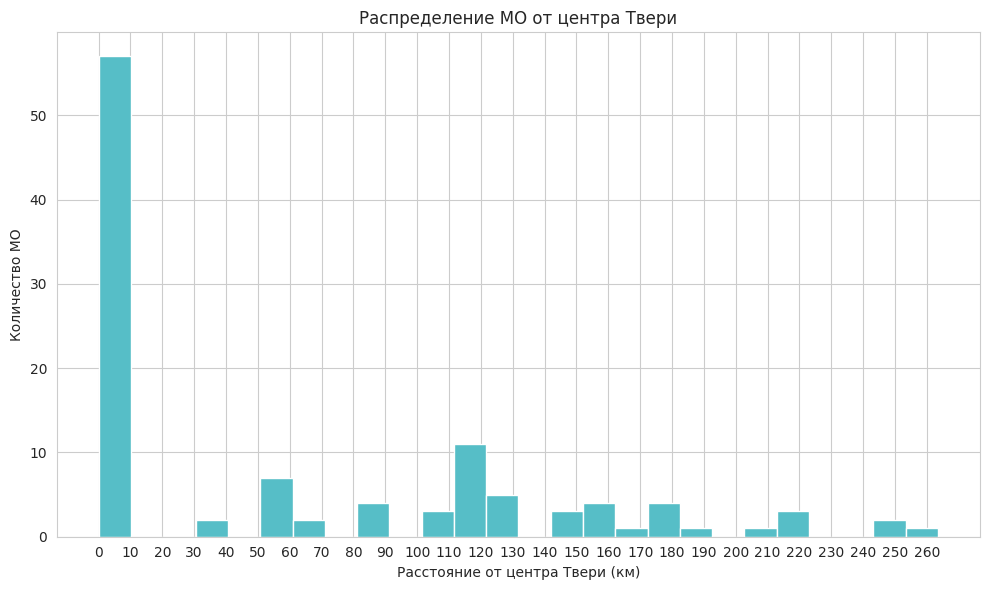

In [16]:
#функция для расчёта расстояния
def center_distance(row):
    tver_coords = (56.8591,35.9118) #координаты центра твери
    mo_coords = tuple(map(float, row['coordinates'].split(',')))
    distance = haversine(tver_coords, mo_coords, unit=Unit.KILOMETERS)
    return distance
#применяем функцию
coord['center_distance'] = coord.apply(center_distance, axis=1)
#проверяем
plt.figure(figsize=(10, 6))
coord['center_distance'].hist(bins = 26)
plt.xlabel('Расстояние от центра Твери (км)')
plt.ylabel('Количество МО')
plt.title('Распределение МО от центра Твери')
plt.xticks(range(0, 270, 10))
plt.tight_layout()
plt.show()

Наибольшее количество учреждений находится в пределах 10 км от центра Твери, остальные медицинские организации неравномерно распределены по пригородам и области.

Все организации, попадающие в радиус 15 км от центра города, будут относиться к городу. А оставшиеся МО мы равномерно разделим на 3 категории:
- Пригород
- Приближённые районы
- Удалённые районы

In [17]:
#присваиваем категории
coord['location_mo'] = pd.cut(coord['center_distance'],
                              bins=[0, 15] + [15 + (coord['center_distance'].max() - 15) * i / 3
                                            for i in range(1, 3)] + [float('inf')],
                              labels=['Город', 'Пригород', 'Районы приближённые', 'Удалённые районы'],
                              right=False)
#проверяем
coord.pivot_table(index='location_mo', values='abbr', aggfunc='count')

,abbr
location_mo,
Город,57
Пригород,15
Районы приближённые,30
Удалённые районы,9


Такое разделение похоже на правду:
- При просмотре статистики по городскому округу город Тверь было 59 МО, из которых 2 учреждения оказались дубликатами.
- Нужды пригорода могут быть покрыты МО, находящимися в городе.
- В районах учреждений меньше, чем в городе, но больше, чем в пригороде, впрочем, диапазон расширяется — и удалённость имеет значение не только от центра Твери, но и организаций друг от друга.

Финальным штрихом можно отформатировать координаты в нужный формат для работы в DataLens.

In [18]:
#подготовим координаты организаций к работе в datalens
for i in range(len(coord)):
    lat, lon = coord.at[i, 'coordinates'].split(", ")
    coord.at[i, 'coordinates'] = f"[{lat},{lon}]"
#проверяем
coord.head()

,organization,abbr,district,address,coordinates,type_mo,center_distance,location_mo
0,"АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ ОБЛАСТИ ""МЕДИЦИНСКИЙ ЦЕНТР ""БЕЛАЯ РОЗА""","АНО ""БЕЛАЯ РОЗА""",городской округ город Тверь,"170100, Тверская область, город Тверь, Тверской пр-кт, д. 14","[56.86053266726136,35.909560612319325]",частная,0.209547,Город
1,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""КОНАКОВСКИЙ ЗАВОД СТАЛЬНЫХ КОНСТРУКЦИЙ""","АО ""КЗСК""",Конаковский район,"171252, Тверская область, г. Конаково, ул. Промышленная, д.1","[56.72231762064035,36.78252888653642]",частная,55.166264,Пригород
2,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ ""КАШИНСКАЯ СТОМАТОЛОГИЧЕСКАЯ ПОЛИКЛИНИКА""","ГБУЗ ""КАШИНСКАЯ СП""",Кашинский городской округ,"Тверская область, г. Кашин, ул. Карла Маркса, д. 24/23","[57.355114792071056,37.6091387505305]",государственная,116.389504,Районы приближённые
3,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ ""КАШИНСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА""","ГБУЗ ""КАШИНСКАЯ ЦРБ""",Кашинский городской округ,"171640, Тверская область, г. Кашин, ул. Вонжинская, 2","[57.35759162268202,37.622431951037704]",государственная,117.223837,Районы приближённые
4,"ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ ТВЕРСКОЙ ОБЛАСТИ ""КИМРСКАЯ ЦЕНТРАЛЬНАЯ РАЙОННАЯ БОЛЬНИЦА""","ГБУЗ ""КИМРСКАЯ ЦРБ""",городской округ город Кимры,"171502, Тверская область, г. Кимры, Борковское шоссе, дом 10","[56.83610336308383,37.36593272292891]",государственная,88.459676,Пригород


Координаты в читаемом DataLens формате.



## Работа над датасетом staff

In [19]:
#удаляем безымянный столбец в таблице сотрудников
staff = staff.drop(columns='Unnamed: 0')
#проверяем
staff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 5 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Дата рождения                      1419 non-null   object
 1   Возраст                            1419 non-null   int64 
 2   Пол                                1419 non-null   object
 3   Организация по основной должности  1414 non-null   object
 4   Основная должность                 1414 non-null   object
dtypes: int64(1), object(4)
memory usage: 55.6+ KB


Столбец успешно удалён.

In [20]:
#переименовываем столбцы
staff.rename(columns={'Дата рождения': 'dob', 'Возраст': 'age', 'Пол': 'sex',
                      'Организация по основной должности': 'organization',
                      'Основная должность': 'profession'}, inplace=True)
#проверяем
staff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419 entries, 0 to 1418
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dob           1419 non-null   object
 1   age           1419 non-null   int64 
 2   sex           1419 non-null   object
 3   organization  1414 non-null   object
 4   profession    1414 non-null   object
dtypes: int64(1), object(4)
memory usage: 55.6+ KB


Наименования столбцов в таблице `staff` успешно переведены на латиницу.

In [21]:
#переводим дату рождения во временной формат
staff['dob'] = pd.to_datetime(staff['dob'], format='%d.%m.%Y')
#проверяем
staff['dob'].head()

,dob
0,1958-01-01
1,1968-11-13
2,1950-02-01
3,1957-02-08
4,1974-11-14


Теперь у нас корректный формат даты рождения сотрудников.

In [22]:
#приводим наименования специальностей к строчному формату
staff['profession'] = staff['profession'].str.lower()
#проверяем
list(staff['profession'].unique())

['врач-анестезиолог-реаниматолог',
 'рентгенолаборант',
 'врач общей практики (семейный врач)',
 'врач-терапевт участковый',
 'врач-педиатр участковый',
 'врач-рентгенолог',
 'врач-хирург',
 nan]

Специальности приведены к нижнему регистру, есть пропуски, которые мы отметили при изучении таблиц.

In [23]:
#выведем пропуски
staff[staff['profession'].isna()].head(10)

,dob,age,sex,organization,profession
180,1958-01-26,66,Муж.,NaN,NaN
565,1981-03-28,43,Жен.,NaN,NaN
736,1982-02-06,42,Муж.,NaN,NaN
928,1985-07-28,39,Жен.,NaN,NaN
1405,1996-03-05,28,Жен.,NaN,NaN


Пропуски в специальности совпадают с пропусками в основном месте работы. Возможно, сейчас они не работают.

Пропусков всего 5, удалим эти строки, так как они не помогут нам при анализе.


In [24]:
#удаляем
staff = staff.dropna().reset_index(drop=True)
#проверяем
staff[staff['profession'].isna()].head()

,dob,age,sex,organization,profession


Больше пропусков нет.

Так как явных дубликатов о сотрудниках не было обнаружено, а информация о них максимально обезличена, мы не сможем определить специалистов, которые задублировались или являются ровесниками в одной организации. На этом основании проверять и проводить очистку специалистов не будем, но проверим, у кого основным местом работы числятся организации, которые мы удалили как неявные дубликаты.
- ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"
- филиал «Больница» Федерального казенного учреждения здравоохранения «Медико-санитарная часть № 69 Федеральной службы исполнения наказаний»

In [25]:
#сохраняем наименования дублей
dupe_filter =  ['ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "ЦЕНТРОМЕД"',
                'филиал «Больница» Федерального казенного учреждения здравоохранения «Медико-санитарная часть № 69 Федеральной службы исполнения наказаний»']
#найдём специалистов из организаций-дубликатов
staff[staff['organization'].isin(dupe_filter)]

,dob,age,sex,organization,profession
451,1965-03-11,59,Муж.,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЦЕНТРОМЕД""",врач-хирург
558,1975-06-28,49,Жен.,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЦЕНТРОМЕД""",врач-хирург
646,1956-04-27,68,Жен.,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЦЕНТРОМЕД""",врач общей практики (семейный врач)
962,1953-12-25,70,Муж.,филиал «Больница» Федерального казенного учреждения здравоохранения «Медико-санитарная часть № 69 Федеральной службы исполнения наказаний»,врач-анестезиолог-реаниматолог


In [26]:
#заменяем организации по индексам
staff.loc[[451, 558, 646], 'organization'] = 'ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ "КЛИНИКА "ЦЕНТРОМЕД""'
staff.loc[962, 'organization'] = 'ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИЯ "МЕДИКО-САНИТАРНАЯ ЧАСТЬ № 69 ФЕДЕРАЛЬНОЙ СЛУЖБЫ ИСПОЛНЕНИЯ НАКАЗАНИЙ"'
#возвращаем ограничение на вывод символов
pd.set_option('display.max_colwidth', 50)
#проверяем
staff.loc[[451, 558, 646, 962]]

,dob,age,sex,organization,profession
451,1965-03-11,59,Муж.,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",врач-хирург
558,1975-06-28,49,Жен.,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",врач-хирург
646,1956-04-27,68,Жен.,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""КЛИН...",врач общей практики (семейный врач)
962,1953-12-25,70,Муж.,ФЕДЕРАЛЬНОЕ КАЗЕННОЕ УЧРЕЖДЕНИЕ ЗДРАВООХРАНЕНИ...,врач-анестезиолог-реаниматолог


Теперь у сотрудников сохранены корректные наименования организаций, что позволит связать их с имеющимися у нас организациями в DataLens.

## Работа над датасетом polygons

Рассмотрим, что нам может пригодиться из файла о полигонах по муниципалитетам Тверской области.

В исходной таблице есть такие данные:
- **osm_ref** — Ссылка на OpenStreetMap, возможно, идентификатор района в базе данных OSM.
- **osm_vers** — Версия данных в OpenStreetMap, относящаяся к этому объекту.
- **territory_id** — Идентификатор территории для каждого муниципального района.
- **year_from** — Год, с которого начинается действие данных.
- **year_to** — Год, до которого действуют данные.
- **t_dict_municipal_districts — Sheet1_municipal_district_name_short** — Краткое название муниципального района.✅
- **t_dict_municipal_districts — Sheet1_oktmo** — Общероссийский классификатор территорий муниципальных образований района.
- **t_dict_municipal_districts — Sheet1_municipal_district_name** — Полное название муниципального района.✅
- **t_dict_municipal_districts — Sheet1_municipal_district_type** — Тип муниципального района.✅
- **t_dict_municipal_districts — Sheet1_municipal_district_status** — Статус муниципального района.
- **t_dict_municipal_districts — Sheet1_shape** — Внутренний идентификатор формы.
- **t_dict_municipal_districts — Sheet1_shape_linked_oktmo** — Идентификатор формы, связанный с ОКТМО.
- **t_dict_municipal_districts — Sheet1_municipal_district_center** — Центр муниципального района.✅
- **t_dict_municipal_districts — Sheet1_source_rosstat** — Источник данных из Росстата, возможно, отчет или база данных.
- **t_dict_municipal_districts — Sheet1_year_from** — Год, с которого начинается действие данных для данного района.
- **t_dict_municipal_districts — Sheet1_year_to** — Год, до которого действуют данные для данного района.
- **t_dict_municipal_districts — Sheet1_territory_id** — Другой идентификатор территории, возможно, для внутреннего использования.
- **t_dict_municipal_districts — Sheet1_change_id_from** — Идентификатор изменения, возможно, когда район был изменён.
- **t_dict_municipal_districts — Sheet1_change_id_to** — Идентификатор изменения, возможно, когда район был изменён.
- **t_dict_municipal_districts — Sheet1_region_code** — Код региона, к которому принадлежит муниципальный район.
- **t_dict_municipal_districts — Sheet1_region_name** — Название региона, к которому принадлежит муниципальный район.
- **t_dict_municipal_districts — Sheet1_municipal_district_center_lat** — Широта центра муниципального района.
- **t_dict_municipal_districts — Sheet1_municipal_district_center_lon** — Долгота центра муниципального района.
- **geometry** — Полигоны, представляющие границы муниципального района.✅

Галкой отмечены столбцы, которые могут нам пригодиться для работы в дальнейшем. Присвоим им короткие названия и обновим датасет.

- **t_dict_municipal_districts — Sheet1_municipal_district_name_short** — district_name
- **t_dict_municipal_districts — Sheet1_municipal_district_name** — ful_name
- **t_dict_municipal_districts — Sheet1_municipal_district_type** — district_type
- **t_dict_municipal_districts — Sheet1_municipal_district_center** — district_center
- **geometry**

In [27]:
#переименовываем столбцы
polygons.rename(columns={'t_dict_municipal_districts — Sheet1_municipal_district_name_short': 'district_name',
                       't_dict_municipal_districts — Sheet1_municipal_district_name': 'ful_name',
                       't_dict_municipal_districts — Sheet1_municipal_district_type': 'district_type',
                       't_dict_municipal_districts — Sheet1_municipal_district_center': 'district_center'}, inplace=True)
#сохраняем нужные столбцы в датасет
polygons = polygons[['district_center','geometry','ful_name','district_name','district_type',]]
#проверяем
polygons

,district_center,geometry,ful_name,district_name,district_type
0,г Вышний Волочек,"MULTIPOLYGON (((34.62629 57.58116, 34.62648 57...",городской округ город Вышний Волочек,Вышний Волочек,городской округ
1,г Кимры,"MULTIPOLYGON (((37.31227 56.85229, 37.31275 56...",городской округ город Кимры,Кимры,городской округ
2,г Ржев,"MULTIPOLYGON (((34.39606 56.23713, 34.39139 56...",городской округ город Ржев,Ржев,городской округ
3,г Торжок,"MULTIPOLYGON (((34.99793 57.00411, 34.9967 57....",городской округ город Торжок,Торжок,городской округ
4,г Тверь,"MULTIPOLYGON (((35.90113 56.93606, 35.9062 56....",городской округ город Тверь,Тверь,городской округ
5,г Торопец,"MULTIPOLYGON (((31.0697 56.94322, 31.07875 56....",муниципальный округ Торопецкий,Торопецкий,муниципальный округ
6,г Торжок,"POLYGON ((34.51135 56.70961, 34.50255 56.71174...",Торжокский муниципальный район,Торжокский,муниципальный район
7,г Старица,"MULTIPOLYGON (((34.86406 56.30661, 34.86101 56...",муниципальный округ Старицкий,Старицкий,муниципальный округ
8,пгт Спирово,"MULTIPOLYGON (((35.5754 57.63323, 35.57507 57....",муниципальный округ Спировский,Спировский,муниципальный округ
9,пгт Сонково,"MULTIPOLYGON (((37.16181 57.88218, 37.16774 57...",муниципальный округ Сонковский,Сонковский,муниципальный округ


Сверка координат показала, что  в столбце `geometry` координаты написаны в формате долготы/широты. Кроме того, есть различия в начале строк: MULTIPOLYGON и POLYGON.
- Необходимо переформатировать данные с границами полигонов.
- Полное наименование муниципалитетов также имеет различия в написании районов относительно таблицы с данными о МО. Нужно будет скорректировать наименования в соответствии с таблицей coord.

In [28]:
#функция для преобразования geometry
def reformat_geometry(geometry):
    coords = []
    if isinstance(geometry, MultiPolygon):
        for polygon in geometry.geoms:
            for coord in polygon.exterior.coords:
                coords.append(f"[{coord[1]},{coord[0]}]")
    elif isinstance(geometry, Polygon):
        for coord in geometry.exterior.coords:
            coords.append(f"[{coord[1]},{coord[0]}]")
    return f'[[{",".join(coords)}]]'
#применяем функцию
polygons['geometry'] = polygons['geometry'].apply(reformat_geometry)
#проверяем
show_info(polygons, whole=False)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   district_center  46 non-null     object
 1   geometry         46 non-null     object
 2   ful_name         46 non-null     object
 3   district_name    46 non-null     object
 4   district_type    46 non-null     object
dtypes: object(5)
memory usage: 1.9+ KB


None

-------------------------


,count,unique,top,freq
district_center,46,38,г Вышний Волочек,3
geometry,46,46,"[[[57.5811568,34.62629],[57.5745189,34.6264787...",1
ful_name,46,46,городской округ город Вышний Волочек,1
district_name,46,43,Кимрский,2
district_type,46,3,муниципальный округ,30


-------------------------


,district_center,geometry,ful_name,district_name,district_type
0,г Вышний Волочек,"[[[57.5811568,34.62629],[57.5745189,34.6264787...",городской округ город Вышний Волочек,Вышний Волочек,городской округ
1,г Кимры,"[[[56.8522914,37.3122663],[56.8546006,37.31275...",городской округ город Кимры,Кимры,городской округ
2,г Ржев,"[[[56.2371255,34.3960583],[56.2372517,34.39138...",городской округ город Ржев,Ржев,городской округ
3,г Торжок,"[[[57.0041069,34.9979349],[57.0043195,34.99670...",городской округ город Торжок,Торжок,городской округ
4,г Тверь,"[[[56.9360617,35.9011321],[56.9312118,35.90619...",городской округ город Тверь,Тверь,городской округ


Теперь координаты полигонов указаны корректно для использования их в DataLens. Но этого недостаточно:
- Центров округов 38 — столько же округов указано в таблице с организациями.
- А всего границ полигонов 46, значит, 8 из них либо являются наложением, либо охватывают большую территорию Тверской области.
- Центр Вышний Волочек повторяется трижды — у нас есть информация о трёх полигонах с единым центром.
- Некоторые короткие наименования также повторяются.

Чтобы объединить в DataLens таблицу с организациями и полигонами, нам требуется сформировать общий столбец. Так как среди полигонов есть повторения, мы можем столкнуться с наложением объектов, потому создадим дополнительную связующую таблицу, через которую объединим две основные.


In [29]:
#функция для извлечения имён собственных
def proper_names(row):
    names = [word for word in row.split() if word[0].isupper()]
    return ' '.join(names)
#применяем функцию
polygons['center_city'] = polygons['district_center'].apply(proper_names)
#удаляем вспомогательный столбец
polygons.drop(columns=['district_center'], inplace=True)
#проверяем
polygons.head()

,geometry,ful_name,district_name,district_type,center_city
0,"[[[57.5811568,34.62629],[57.5745189,34.6264787...",городской округ город Вышний Волочек,Вышний Волочек,городской округ,Вышний Волочек
1,"[[[56.8522914,37.3122663],[56.8546006,37.31275...",городской округ город Кимры,Кимры,городской округ,Кимры
2,"[[[56.2371255,34.3960583],[56.2372517,34.39138...",городской округ город Ржев,Ржев,городской округ,Ржев
3,"[[[57.0041069,34.9979349],[57.0043195,34.99670...",городской округ город Торжок,Торжок,городской округ,Торжок
4,"[[[56.9360617,35.9011321],[56.9312118,35.90619...",городской округ город Тверь,Тверь,городской округ,Тверь


In [30]:
#сравниваем с организациями
coord.head()

,organization,abbr,district,address,coordinates,type_mo,center_distance,location_mo
0,АВТОНОМНАЯ НЕКОММЕРЧЕСКАЯ ОРГАНИЗАЦИЯ ТВЕРСКОЙ...,"АНО ""БЕЛАЯ РОЗА""",городской округ город Тверь,"170100, Тверская область, город Тверь, Тверско...","[56.86053266726136,35.909560612319325]",частная,0.209547,Город
1,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""КОНАКОВСКИЙ ЗАВОД СТАЛЬН...","АО ""КЗСК""",Конаковский район,"171252, Тверская область, г. Конаково, ул. Про...","[56.72231762064035,36.78252888653642]",частная,55.166264,Пригород
2,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,"ГБУЗ ""КАШИНСКАЯ СП""",Кашинский городской округ,"Тверская область, г. Кашин, ул. Карла Маркса, ...","[57.355114792071056,37.6091387505305]",государственная,116.389504,Районы приближённые
3,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,"ГБУЗ ""КАШИНСКАЯ ЦРБ""",Кашинский городской округ,"171640, Тверская область, г. Кашин, ул. Вонжин...","[57.35759162268202,37.622431951037704]",государственная,117.223837,Районы приближённые
4,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХ...,"ГБУЗ ""КИМРСКАЯ ЦРБ""",городской округ город Кимры,"171502, Тверская область, г. Кимры, Борковское...","[56.83610336308383,37.36593272292891]",государственная,88.459676,Пригород


В таблице с муниципальными образованиями нам нужно будет определить названия населённых пунктов и сформировать их полные наименования по аналогии. В таблице с полигонами также нужно выделить совпадения по столбцу с адресами и сформировать столбец с городами в именительном падеже в таблице организаций.

In [31]:
#выведем наименования муниципалитетов из coord
sorted(coord['district'].unique().tolist())

['Андреапольский муниципальный округ',
 'Бежецкий район',
 'Бельский район',
 'Бологовский район',
 'Весьегонский муниципальный округ',
 'Вышневолоцкий городской округ',
 'Городской округ ЗАТО Озёрный',
 'Городской округ ЗАТО Солнечный',
 'Жарковский район',
 'Западнодвинский муниципальный округ',
 'Зубцовский район',
 'Калязинский район',
 'Кашинский городской округ',
 'Кесовогорский район',
 'Конаковский район',
 'Краснохолмский муниципальный округ',
 'Кувшиновский район',
 'Лесной муниципальный округ',
 'Лихославльский муниципальный округ',
 'Максатихинский район',
 'Молоковский муниципальный округ',
 'Нелидовский городской округ',
 'Оленинский муниципальный округ',
 'Осташковский городской округ',
 'Пеновский муниципальный округ',
 'Рамешковский муниципальный округ',
 'Сандовский муниципальный округ',
 'Селижаровский муниципальный округ',
 'Сонковский район',
 'Спировский муниципальный округ',
 'Старицкий район',
 'Торопецкий район',
 'Удомельский городской округ',
 'Фировский райо

In [32]:
#переименовываем округа зато
coord['district'] = (coord['district'].str.replace('Г','г', regex=True)
                                      .str.replace('ё','е', regex=True)
                                      .str.replace('ЗАТО','зато', regex=True))
#применяем функцию
coord['district_name'] = coord['district'].apply(proper_names)
#возвращаем написание зато
coord['district'] = coord['district'].str.replace('зато','ЗАТО', regex=True)
#проверяем
sorted(coord['district_name'].unique().tolist())

['Андреапольский',
 'Бежецкий',
 'Бельский',
 'Бологовский',
 'Весьегонский',
 'Вышневолоцкий',
 'Жарковский',
 'Западнодвинский',
 'Зубцовский',
 'Калязинский',
 'Кашинский',
 'Кесовогорский',
 'Кимры',
 'Конаковский',
 'Краснохолмский',
 'Кувшиновский',
 'Лесной',
 'Лихославльский',
 'Максатихинский',
 'Молоковский',
 'Нелидовский',
 'Озерный',
 'Оленинский',
 'Осташковский',
 'Пеновский',
 'Рамешковский',
 'Ржев',
 'Сандовский',
 'Селижаровский',
 'Солнечный',
 'Сонковский',
 'Спировский',
 'Старицкий',
 'Тверь',
 'Торжок',
 'Торопецкий',
 'Удомельский',
 'Фировский']

In [33]:
#функция для создания нового столбца с наименованиями округов в полигонах
def create_new_column(row):
    if 'ЗАТО ' in row['ful_name']:
        return f'городской округ ЗАТО {row["district_name"]}'
    elif 'город ' in row['ful_name']:
        return f'городской округ город {row["district_name"]}'
    elif 'район' in row['ful_name']:
        return f'{row["district_name"]} район'
    else:
        return f'{row["district_name"]} {row["district_type"]}'
#создаем новый столбец
polygons['district'] = polygons.apply(create_new_column, axis=1)
#выведем уникальные наименования полигонов
sorted(polygons['district'].unique().tolist())

['Андреапольский муниципальный округ',
 'Бежецкий муниципальный округ',
 'Бельский муниципальный округ',
 'Бологовский муниципальный округ',
 'Весьегонский муниципальный округ',
 'Вышневолоцкий городской округ',
 'Вышневолоцкий район',
 'Жарковский муниципальный округ',
 'Западнодвинский муниципальный округ',
 'Зубцовский муниципальный округ',
 'Калининский муниципальный округ',
 'Калязинский муниципальный округ',
 'Кашинский городской округ',
 'Кесовогорский муниципальный округ',
 'Кимрский муниципальный округ',
 'Кимрский район',
 'Конаковский муниципальный округ',
 'Краснохолмский муниципальный округ',
 'Кувшиновский муниципальный округ',
 'Лесной муниципальный округ',
 'Лихославльский муниципальный округ',
 'Максатихинский муниципальный округ',
 'Молоковский муниципальный округ',
 'Нелидовский городской округ',
 'Оленинский муниципальный округ',
 'Осташковский городской округ',
 'Пеновский муниципальный округ',
 'Рамешковский муниципальный округ',
 'Ржевский муниципальный округ',
 

In [34]:
#функция для поиска совпадений
def find_center_city(df):
    for city in polygons['center_city']:
        if city in df:
            return city
    return None
#заменим ё на е
coord['address'] = coord['address'].str.replace('ё','е', regex=True)
#применяем функцию к каждому адресу
coord['center_city'] = coord['address'].apply(find_center_city)
#выведем уникальные наименования
coord['center_city'].unique()

array(['Тверь', 'Конаково', 'Кашин', 'Кимры', 'Сандово', 'Осташков',
       'Максатиха', 'Андреаполь', 'Бежецк', 'Белый', 'Бологое',
       'Весьегонск', 'Вышний Волочек', 'Жарковский', 'Западная Двина',
       'Зубцов', 'Калязин', 'Кесова Гора', 'Ржев', 'Красный Холм',
       'Кувшиново', 'Лихославль', 'Молоково', 'Нелидово', 'Оленино',
       'Пено', 'Рамешки', 'Селижарово', 'Сонково', 'Спирово', 'Старица',
       'Торжок', 'Торопец', 'Фирово', 'Лесное', 'Озерный', 'Удомля',
       'Солнечный', None], dtype=object)

In [35]:
#рассмотрим пропуски
coord[coord['center_city'].isna()]

,organization,abbr,district,address,coordinates,type_mo,center_distance,location_mo,district_name,center_city
106,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕН...,ФГБУЗ МСЧ № 57 ФМБА РОССИИ,Конаковский район,"171261, Тверская область, Конаковский район, п...","[56.66854037451462,36.29478252344066]",государственная,31.524249,Пригород,Конаковский,None


Определить населённый пункт по указанному адресу не получилось, но мы можем сказать, что это место находится в Конаковском районе, а точнее, в населённом пункте Конаково.

In [36]:
#заменяем значение в одной строке
coord.at[106, 'center_city'] = 'Конаково'

In [37]:
#формируем связующую таблицу
join_df = coord[['center_city','district_name','district']].drop_duplicates().reset_index(drop=True)
#проверяем
join_df

,center_city,district_name,district
0,Тверь,Тверь,городской округ город Тверь
1,Конаково,Конаковский,Конаковский район
2,Кашин,Кашинский,Кашинский городской округ
3,Кимры,Кимры,городской округ город Кимры
4,Сандово,Сандовский,Сандовский муниципальный округ
5,Осташков,Осташковский,Осташковский городской округ
6,Максатиха,Максатихинский,Максатихинский район
7,Андреаполь,Андреапольский,Андреапольский муниципальный округ
8,Бежецк,Бежецкий,Бежецкий район
9,Белый,Бельский,Бельский район


В индексе 18 обнаружена ошибка: по адресу находится объект в городе Ржев, но по району он относится к городскому округу города Тверь. Необходимо найти строки с таким сочетанием.

In [38]:
coord[(coord['center_city'] == 'Ржев') & (coord['district'] == 'городской округ город Тверь')]

,organization,abbr,district,address,coordinates,type_mo,center_distance,location_mo,district_name,center_city
30,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ЗДРАВООХР...,"ГБУЗ ""КДБ №2""",городской округ город Тверь,"170023, г. Тверь, ул. Ржевская, 4","[56.85275598238039,35.84721077626297]",государственная,3.989593,Город,Тверь,Ржев


В процессе применения функции возникла ошибка из-за улицы, в названии которой присутствует слово «Ржев».

Необходимо внести изменения в значение столбца и повторно собрать таблицу.


In [39]:
#заменяем значение в одной строке
coord.at[30, 'center_city'] = 'Тверь'
#формируем связующую таблицу дубль два
join_df = coord[['center_city','district_name','district']].drop_duplicates().reset_index(drop=True)
#проверяем
join_df

,center_city,district_name,district
0,Тверь,Тверь,городской округ город Тверь
1,Конаково,Конаковский,Конаковский район
2,Кашин,Кашинский,Кашинский городской округ
3,Кимры,Кимры,городской округ город Кимры
4,Сандово,Сандовский,Сандовский муниципальный округ
5,Осташков,Осташковский,Осташковский городской округ
6,Максатиха,Максатихинский,Максатихинский район
7,Андреаполь,Андреапольский,Андреапольский муниципальный округ
8,Бежецк,Бежецкий,Бежецкий район
9,Белый,Бельский,Бельский район


Теперь мы располагаем начальным вариантом таблицы, содержащей 38 уникальных названий муниципальных образований. Чтобы предотвратить пересечение полигонов в местах расположения единых центров, мы подготовим координаты полигонов по слоям. Сначала мы определим координаты для муниципальных округов, затем для районов, городских округов, городов и закрытых административно-территориальных образований.

In [40]:
#функция для сортировки координат полигонов по слоям
def assign_geometry(row):
    municipal_district = None
    municipal_area = None
    city = None
    municipal_city = None
    matching_polygons = polygons[polygons['center_city'] == row['center_city']]

    for _, polygon_row in matching_polygons.iterrows():
        if polygon_row['district_type'] == 'муниципальный округ':
            municipal_district = polygon_row['geometry']
        elif polygon_row['district_type'] == 'муниципальный район':
            municipal_area = polygon_row['geometry']
        elif polygon_row['district_type'] == 'городской округ':
            if 'город ' in polygon_row['district'] or 'ЗАТО' in polygon_row['district']:
                city = polygon_row['geometry']
            else:
                municipal_city = polygon_row['geometry']

    return pd.Series([municipal_district, municipal_area, city, municipal_city])
#применяем функцию
join_df[['municipal_district', 'municipal_area', 'city', 'municipal_city']] = join_df.apply(assign_geometry, axis=1)
join_df

,center_city,district_name,district,municipal_district,municipal_area,city,municipal_city
0,Тверь,Тверь,городской округ город Тверь,"[[[56.5351373,35.3844429],[56.5359849,35.39168...",None,"[[[56.9360617,35.9011321],[56.9312118,35.90619...",None
1,Конаково,Конаковский,Конаковский район,"[[[56.3781215,35.995393],[56.3915101,35.988830...",None,None,None
2,Кашин,Кашинский,Кашинский городской округ,None,None,None,"[[[57.1415261,37.1194377],[57.1470503,37.12296..."
3,Кимры,Кимры,городской округ город Кимры,"[[[57.3309099,36.8645011],[57.3297308,36.87780...","[[[57.3297308,36.877804],[57.3198993,36.884853...","[[[56.8522914,37.3122663],[56.8546006,37.31275...",None
4,Сандово,Сандовский,Сандовский муниципальный округ,"[[[58.4322379,35.7681094],[58.4319799,35.78838...",None,None,None
5,Осташков,Осташковский,Осташковский городской округ,None,None,None,"[[[57.4516683,32.8715328],[57.4499162,32.88806..."
6,Максатиха,Максатихинский,Максатихинский район,"[[[57.6300988,35.5708927],[57.6299097,35.57111...",None,None,None
7,Андреаполь,Андреапольский,Андреапольский муниципальный округ,"[[[56.9090665,31.3908557],[56.9093961,31.39619...",None,None,None
8,Бежецк,Бежецкий,Бежецкий район,"[[[57.5419891,36.1166765],[57.5615282,36.11340...",None,None,None
9,Белый,Бельский,Бельский район,"[[[55.6748372,32.4415716],[55.6788437,32.43759...",None,None,None


В результате мы получили не просто объединяющую таблицу, а полноценный инструмент для работы с полигонами. Он идеально подойдёт для использования в DataLens.

In [41]:
#удаляем лишние столбцы
coord.drop(columns=['district_name'], inplace=True)
join_df.drop(columns=['district_name','district'], inplace=True)

In [42]:
#формируем файлы для визуализации в datalens
coord.to_csv('coordinates.csv', index=False)
staff.to_csv('staff.csv', index=False)
join_df.to_csv('polygons.csv', index=False)

Результаты с картой оказались не такими, как ожидалось. Поэтому загрузим карту с двумя округами, которые на текущих координатах портят внешний вид.

Идея сортировки по столбцам оказалась излишней. Большое количество слоёв в полигонах затрудняет работу с градиентом. Поэтому мы вручную переместим координаты в общий столбец для обоих округов, но не будем дублировать координаты, которые создают двойное наложение на карте.

In [43]:
#в таблице сохранены только нужные строки
poligon = pd.read_csv("https://docs.google.com/spreadsheets/d/1k06-vy1Lxy/gviz/tq?tqx=out:csv&gid=1697638289")
poligon

,center_city,municipal_district,municipal_area,city,municipal_city
0,Бологое,"[[[57.7930597,33.5700254],[57.7924428,33.57238...","[[[58.1609206,33.7811993],[58.1521767,33.79784...",NaN,NaN
1,Озерный,"[[[57.7394689,33.5864727],[57.7463399,33.56622...","[[[57.7146157,33.5551629],[57.7153969,33.55927...",NaN,NaN


In [44]:
#объединяем строки
df = pd.concat([join_df, poligon], ignore_index=True)
#переносим значения в один столбец
df.loc[[2], 'municipal_district'] = df.loc[[2], 'municipal_city']
df.loc[[5], 'municipal_district'] = df.loc[[5], 'municipal_city']
df.loc[[12], 'municipal_district'] = df.loc[[12], 'municipal_city']
df.loc[[22], 'municipal_district'] = df.loc[[22], 'municipal_city']
df.loc[[31], 'municipal_district'] = df.loc[[31], 'municipal_area']
df.loc[[36], 'municipal_district'] = df.loc[[36], 'municipal_city']
df.loc[10, 'municipal_district'] = df.loc[38, 'municipal_area']
df.loc[35, 'municipal_district'] = df.loc[39, 'municipal_area']
df.loc[35, 'city'] = None
#удаляем лишние столбцы
df.drop(columns=['municipal_area','municipal_city'], inplace=True)
#сохраняем данные в файл
df.to_csv('polygon.csv', index=False)

В рамках предобработки сделано следующее:

- Переименованы столбцы в трех таблицах, чтобы сделать работу с ними более удобной.
- Устранены пропуски и дубликаты в данных о сотрудниках и медицинских организациях.
- Внесены дополнительные категории в информацию о медицинских организациях.
- Отформатированы координаты организаций для использования в DataLens.
- Дата рождения специалистов приведена в корректный формат даты.
- Специальности специалистов представлены в едином формате.
- В таблице с организациями выведен новый столбец для объединения данных с полигонами в DataLens.
- Создана таблица с полигонами, в которой указаны наименования муниципалитетов и координаты полигонов.
- Все таблицы выгружены для работы в BI-системе.

# Исследовательский анализ

Чтобы более глубоко изучить информацию о медицинских организациях и работающих в них сотрудниках, объединим данные из таблиц и построим графики.

In [45]:
#объединяем таблицы
df = pd.merge(coord, staff, on='organization', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1414 entries, 0 to 1413
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   organization     1414 non-null   object        
 1   abbr             1414 non-null   object        
 2   district         1414 non-null   object        
 3   address          1414 non-null   object        
 4   coordinates      1414 non-null   object        
 5   type_mo          1414 non-null   object        
 6   center_distance  1414 non-null   float64       
 7   location_mo      1414 non-null   category      
 8   center_city      1414 non-null   object        
 9   dob              1414 non-null   datetime64[ns]
 10  age              1414 non-null   int64         
 11  sex              1414 non-null   object        
 12  profession       1414 non-null   object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 134.3+ KB


Объединение прошло успешно, данные не утеряны. Чтобы получить информативные графики по различным переменным, мы будем использовать функцию с адаптивным набором параметров. Это позволит нам работать с различными вариантами сводных таблиц, используя всего одну команду.

In [46]:
#общая функция линейчатого графика с накоплением
def cumulative_barh(figsize, title, index, xlabel, distance, *data_labels, show_totals=True):
    """
    Используемые параметры:
    - figsize: размер графика
    - title: заголовок графика
    - index: название столбца, по которому были расчёты - индекс в pivot_table
    - xlabel: подпись оси х
    - distance: расстояние общего значения от столбца
    - *data_labels: данные и метки для значений (можно передавать любое количество пар (данные, метка))
    - show_totals: флаг для отображения общих значений
    """
    #проверяем на чётность количество аргументов
    if len(data_labels) % 2 != 0:
        raise ValueError("Количество аргументов data_labels должно быть четным (данные и метка)")

    num_bars = len(data_labels) // 2
    data = [data_labels[i * 2] for i in range(num_bars)]
    labels = [data_labels[i * 2 + 1] for i in range(num_bars)]

    #создаем накопления
    cumulative_data = np.zeros_like(data[0])
    fig, ax = plt.subplots(figsize=figsize)

    for i in range(num_bars):
        if i == 0:
            bar = ax.barh(index, data[i], label=labels[i])
        else:
            bar = ax.barh(index, data[i], left=cumulative_data, label=labels[i])

        #обновляем накопления
        cumulative_data += data[i]

        #добавляем подписи внутри столбцов
        for j in range(len(index)):
            if data[i][j] != 0:
                ax.text(cumulative_data[j] - data[i][j] / 2, j, str(int(data[i][j])), 
                        ha='center', va='center', color='white', fontsize=10)

    #добавляем общие значения
    if show_totals:
        for i in range(len(index)):
            total = cumulative_data[i]
            ax.text(total + distance, i, str(int(total)), ha='left', va='center', fontsize=12)
    #оформляем график
    ax.invert_yaxis()
    ax.grid(axis='y', linestyle='None')
    ax.margins(y=0.01)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel(xlabel)
    ax.legend()
    plt.tight_layout()
    plt.show()

#вспомогательная функция для сокращения пар в data_labels для функции cumulative_barh
def plot_distribution(figsize, title, index, xlabel, distance, df, values, show_totals=True):
    data_labels = []
    #итерируем по значениям и собираем данные и метки
    for value in values:
        data = df[value].fillna(0)
        data_labels.append(data)
        data_labels.append(value)
    #вызываем функцию cumulative_barh с собранными данными
    cumulative_barh(figsize, title, index, xlabel, distance, *data_labels, show_totals=show_totals)

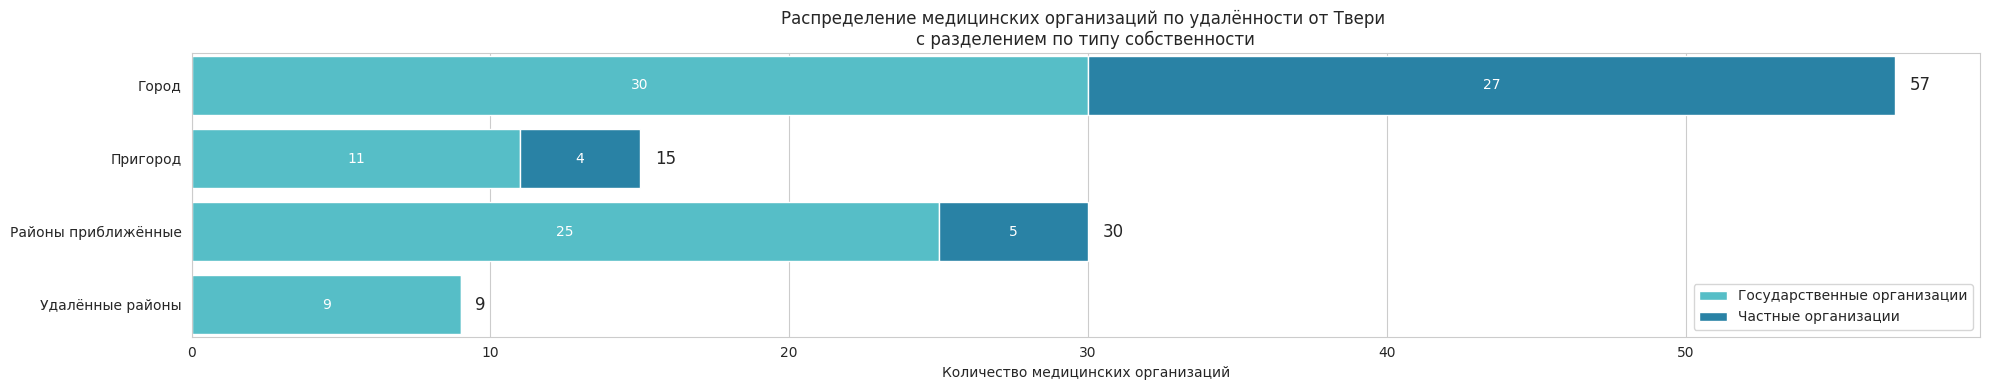

In [47]:
#создаём сводную таблицу по типу мо и удалённости
pivot_location_mo = df.pivot_table(index='location_mo', columns='type_mo', values='abbr', aggfunc='nunique')
#выводим график
cumulative_barh((20, 4), 'Распределение медицинских организаций по удалённости от Твери \nс разделением по типу собственности',
                pivot_location_mo.index, 'Количество медицинских организаций', 0.5,
                pivot_location_mo['государственная'].fillna(0), 'Государственные организации',
                pivot_location_mo['частная'].fillna(0), 'Частные организации')

Большая часть медицинских учреждений сосредоточена в Твери. В пригороде их количество существенно сокращается, но при удалении от областного центра их число возрастает. Однако в целом по области количество медицинских организаций меньше, чем в самой Твери.

Интересно отметить, что в областном центре количество частных медицинских учреждений почти не уступает государственным, тогда как в области их число значительно ниже.

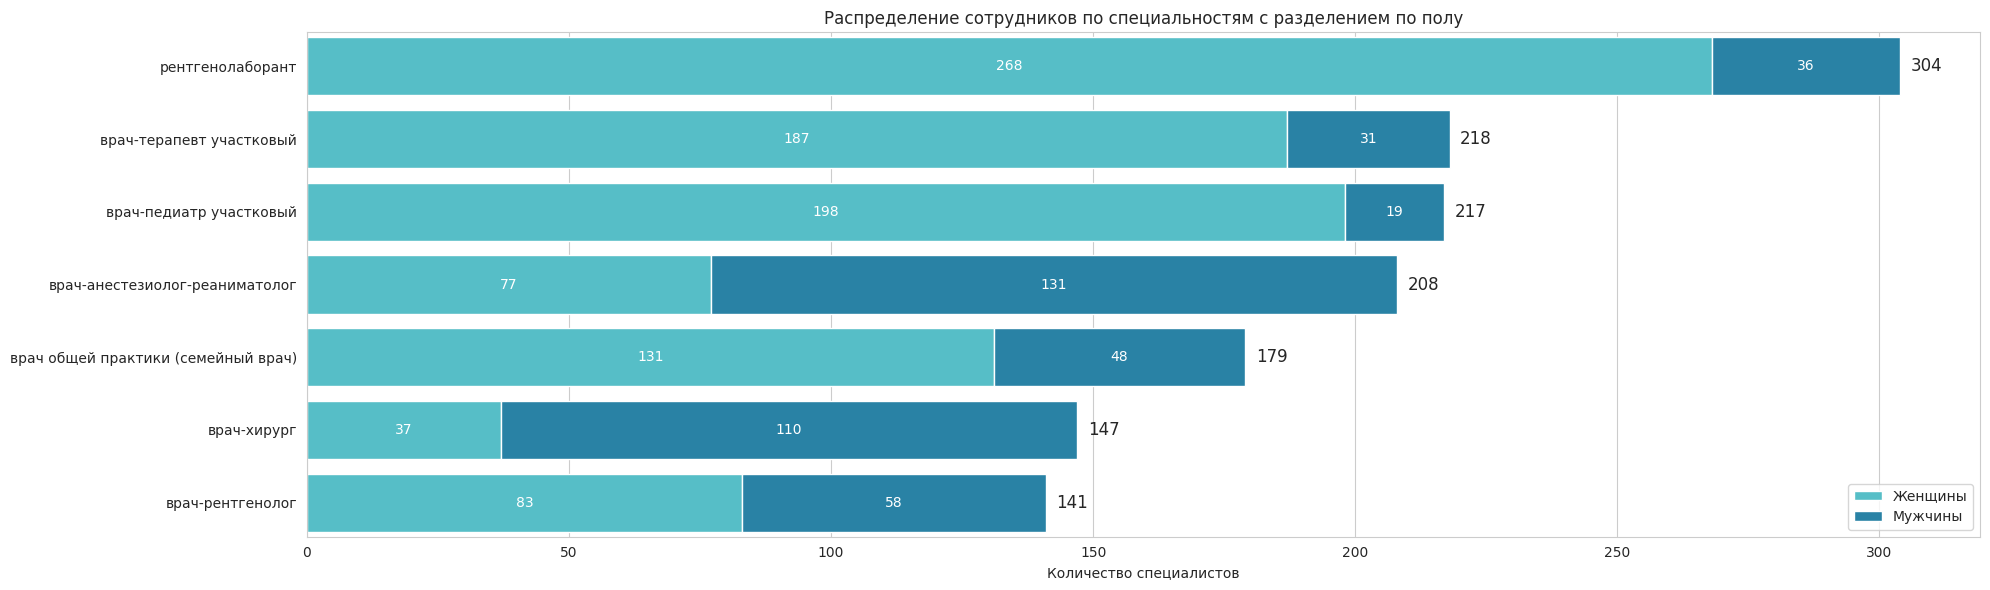

In [48]:
#создаём сводную таблицу по полу и специальностям
pivot_profession = (df.pivot_table(index='profession', columns='sex', values='age', aggfunc='count')
                      .assign(total=lambda x: x.sum(axis=1))
                      .sort_values(by='total', ascending=False))
#выводим график
cumulative_barh((20, 6), 'Распределение сотрудников по специальностям с разделением по полу',
                pivot_profession.index, 'Количество специалистов', 2,
                pivot_profession['Жен.'].fillna(0), 'Женщины',
                pivot_profession['Муж.'].fillna(0), 'Мужчины')

- Среди рассматриваемых специалистов наиболее представлены рентгенолаборанты, среди которых подавляющее большинство — женщины.
- Также большая доля женщин отмечается в сферах первичной медицинской помощи, особенно среди врачей-терапевтов и врачей-педиатров.
- Количество реаниматологов, хотя и уступает двум предыдущим специализациям, но почти две трети из них — мужчины.
- Однако самая высокая доля мужчин наблюдается среди хирургов.

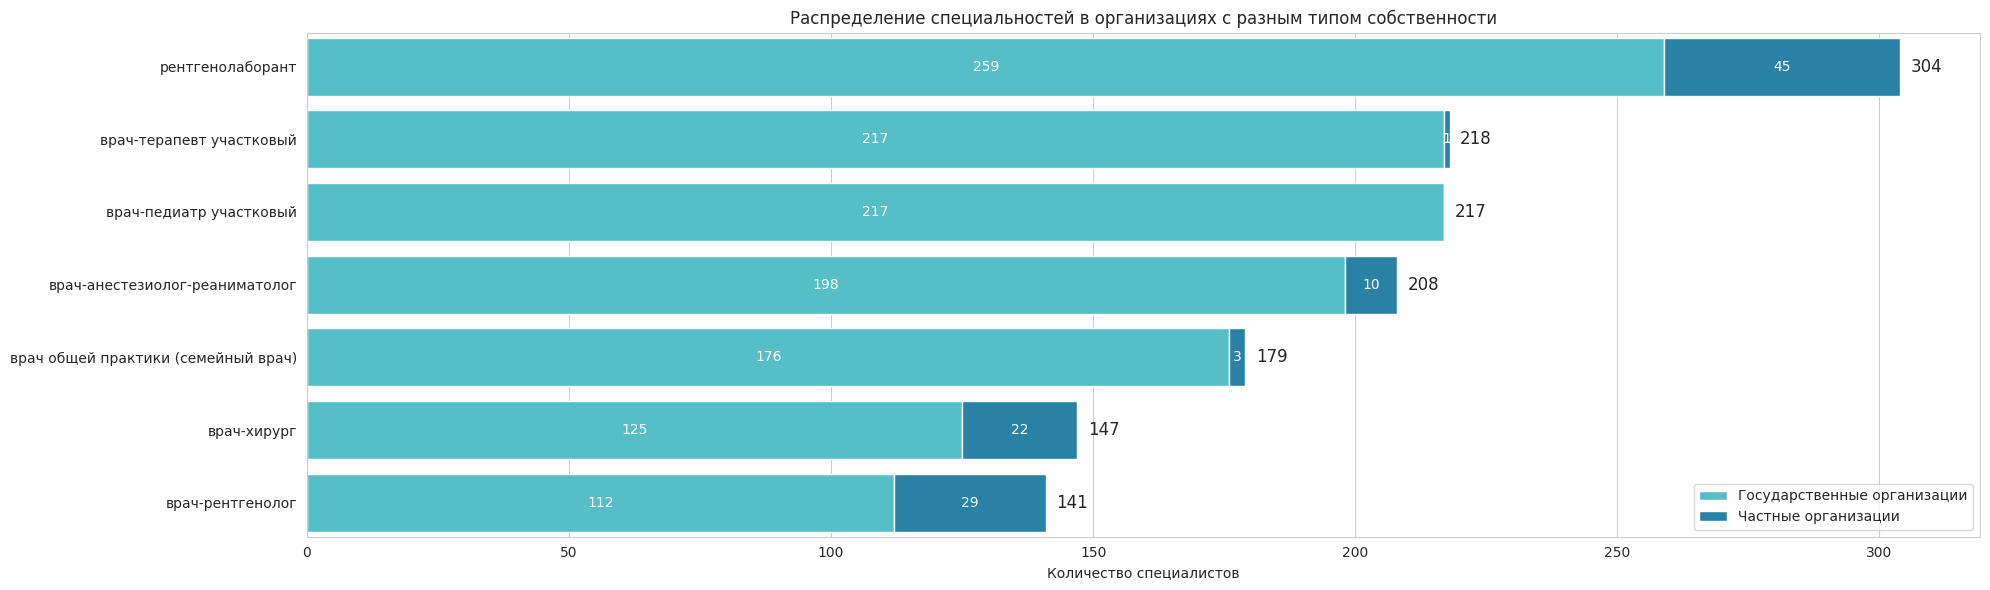

In [49]:
#создаём сводную таблицу по типу мо и специальностям
pivot_staff_type_mo = (df.pivot_table(index='profession', columns='type_mo', values='age', aggfunc='count')
                         .assign(total=lambda x: x.sum(axis=1))
                         .sort_values(by='total', ascending=False))
#выводим график
cumulative_barh((20, 6), 'Распределение специальностей в организациях с разным типом собственности',
                pivot_staff_type_mo.index, 'Количество специалистов', 2,
                pivot_staff_type_mo['государственная'].fillna(0), 'Государственные организации',
                pivot_staff_type_mo['частная'].fillna(0), 'Частные организации')

В частных медицинских организациях, как правило, можно встретить рентгенолаборантов и врачей-рентгенологов. Среди специалистов, предоставляющих услуги в таких учреждениях, есть и хирурги.

Однако большинство врачей работают в государственных медицинских организациях. Именно там можно найти педиатров.

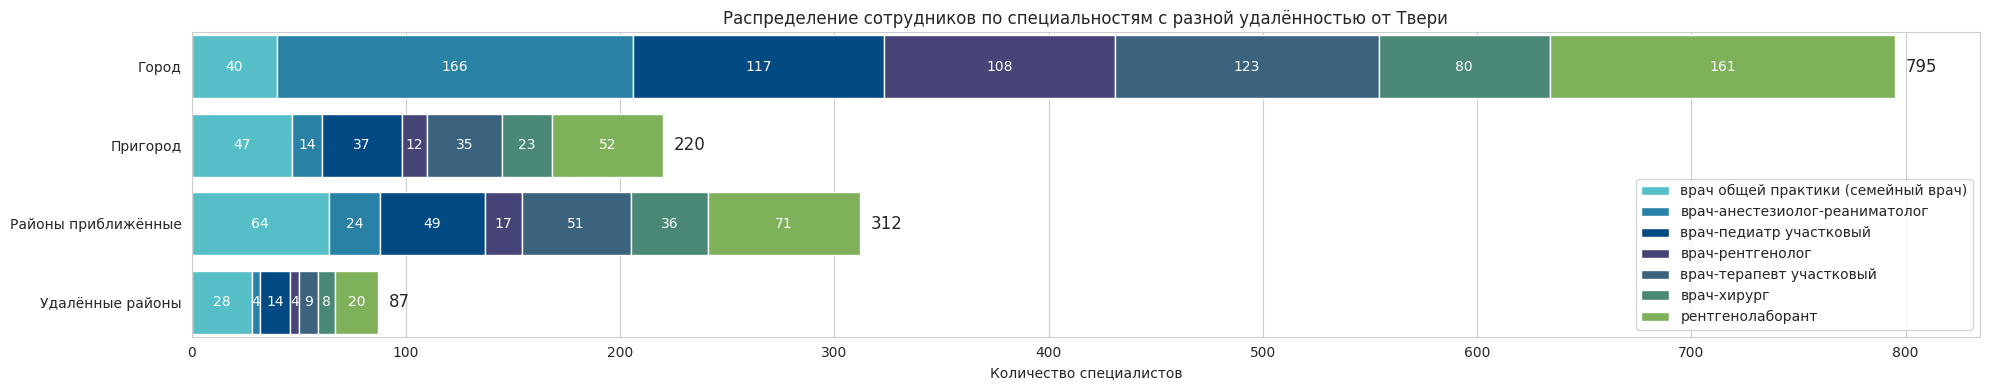

In [50]:
#создаём сводную таблицу по удалённости и специальностям
pivot_location_profession = df.pivot_table(index='location_mo', columns='profession', values='age', aggfunc='count')
#список профессий для values в функцию plot_distribution
professions = ['врач общей практики (семейный врач)','врач-анестезиолог-реаниматолог','врач-педиатр участковый',
               'врач-рентгенолог','врач-терапевт участковый','врач-хирург','рентгенолаборант']
#выводим график
plot_distribution((20, 4), 'Распределение сотрудников по специальностям с разной удалённостью от Твери',
                  pivot_location_profession.index, 'Количество специалистов', 5, pivot_location_profession, professions)

В городе работает примерно одинаковое количество анестезиологов-реаниматологов и рентгенолаборантов, и их число преобладает. На втором месте по количеству — участковые специалисты: врачи-терапевты и педиатры. Наименьшая доля в городе — у семейных врачей.

В пригородах и районах, расположенных дальше от Твери, доля семейных врачей растёт. Чем дальше от города, тем меньше становится узкопрофильных специалистов: анестезиологов-реаниматологов, рентгенологов и хирургов.

In [51]:
#подсчитаем количество сотрудников по организациям
staff_count = df.groupby('organization').size().reset_index(name='staff_count')
#объединим таблицы
merge_df = pd.merge(staff_count,coord[['organization','type_mo','location_mo']], on='organization', how='inner')
#посчитаем среднюю наполненность организаций сотрудниками по локациям
round(merge_df.pivot_table(index='location_mo', columns='type_mo', values='staff_count', aggfunc='mean'))

type_mo,государственная,частная
location_mo,,
Город,23.0,4.0
Пригород,20.0,1.0
Районы приближённые,12.0,1.0
Удалённые районы,10.0,NaN


In [52]:
#посчитаем медианную наполненность организаций сотрудниками по локациям
round(merge_df.pivot_table(index='location_mo', columns='type_mo', values='staff_count', aggfunc='median'))

type_mo,государственная,частная
location_mo,,
Город,12.0,1.0
Пригород,12.0,1.0
Районы приближённые,7.0,1.0
Удалённые районы,9.0,NaN


Разница между средними и медианными значениями показывает, что в государственных организациях есть учреждения с большим штатом сотрудников, но в половине из них работает менее 12 специалистов по рассматриваемым направлениям. В частных же медицинских организациях количество специалистов обычно составляет примерно один на учреждение.

Следует отметить, что в отдалённых районах разница между средним и медианным значениями наполненности медицинских организаций уменьшается, что свидетельствует о более равномерном распределении сотрудников.

Посмотрим, какие специалисты чаще всего встречаются в государственных и частных медицинских организациях.

In [53]:
#сводная таблица с распределение врачей по возрастам в зависимости от удалённости
round(df.groupby('location_mo')['age'].agg(['min','mean','median','max']))

,min,mean,median,max
location_mo,,,,
Город,21,43.0,40.0,83
Пригород,23,46.0,44.0,84
Районы приближённые,22,50.0,51.0,86
Удалённые районы,25,52.0,56.0,75


В городе трудится более молодой состав специалистов: половина сотрудников не достигли 40 лет.

Примечательно, что по мере удаления от города возрастные показатели — минимальный, средний и медианный — становятся всё выше. Это свидетельствует о том, что в отдалённых районах сотрудники в среднем старше.

Но чтобы ответить на поставленные вопросы, нам потребуется добавить категории по возрастам.

In [54]:
#функция для присвоения категории по возрасту
def age_range(age):
    if age < 24:
        return 'до 24'
    elif 24 <= age <= 27:
        return 'до 27'
    elif age <= 30:
        return 'до 30'
    elif age <= 35:
        return 'до 35'
    elif age <= 50:
        return 'до 50'
    elif age < 60:
        return 'до 60'
    else:
        return 'от 60'
#применяем функцию
df['age_range'] = df['age'].apply(age_range)

## Оценка кадрового голода
**В связи с тем, что в Твери заработная плата выше, чем в районах области, наибольший «кадровый голод» первичного звена ощущается в районах, расположенных ближе к городу и наименьший – в отдаленных районах. Так ли это? В каких районах самые молодые, а в каких - самые старые врачи?**

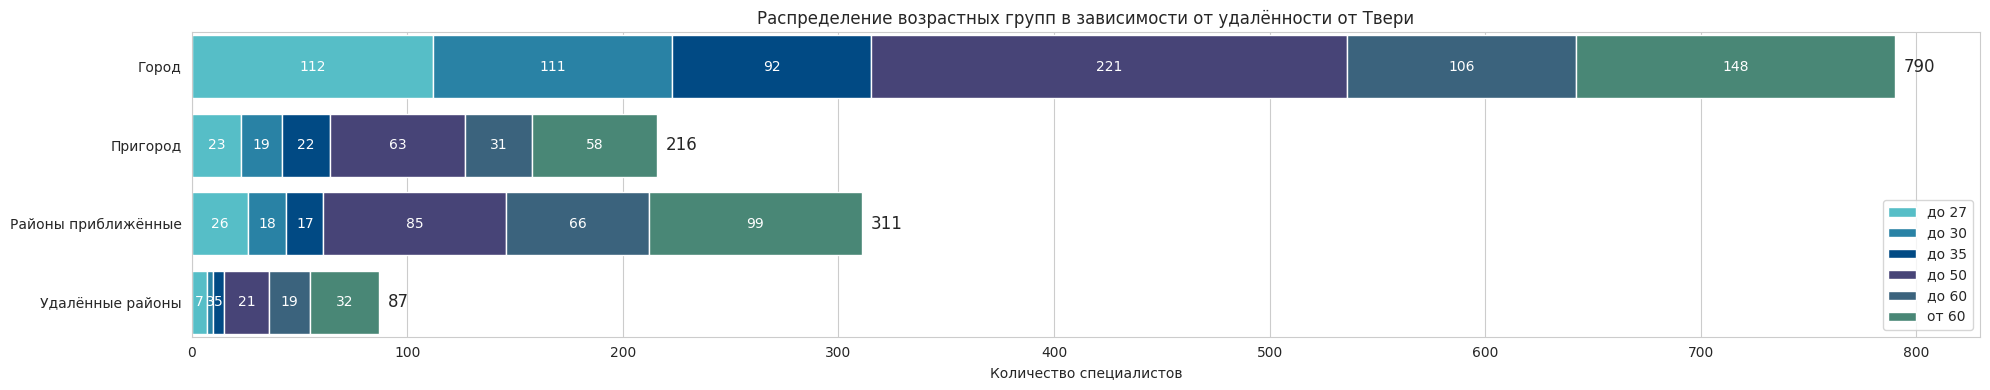

In [55]:
#создаём сводную таблицу по удалённости и возрастным группам
pivot_age_location = df.pivot_table(index='location_mo', columns='age_range', values='age', aggfunc='count')
#возрастные группы для values в функцию plot_distribution
age_group = ['до 27','до 30','до 35','до 50','до 60','от 60']
#выводим график
plot_distribution((20, 4), 'Распределение возрастных групп в зависимости от удалённости от Твери',
                  pivot_age_location.index, 'Количество специалистов', 4, pivot_age_location, age_group)

На основе данных, представленных на графике, можно сделать следующие выводы:
- В городе работает наибольшее количество врачей в возрасте до 35 лет. В то же время, в удаленных районах наблюдается заметное снижение числа молодых специалистов. Например, в городе насчитывается 223 врача до 30 лет, в то время как в отдаленных районах их количество составляет всего 10.
- В городе также отмечается значительное число врачей старше 60 лет, что свидетельствует о том, что, несмотря на преобладание молодых специалистов, в городе присутствует достаточное количество опытных врачей.
- В удаленных районах количество врачей в молодых возрастных группах наименьшее, в то время как число врачей старшего возраста существенно возрастает. Это указывает на то, что врачи в этих районах имеют более старший возраст.

Таким образом, в окрестностях Твери наблюдается нехватка молодых специалистов, особенно в районах, расположенных за городом. Молодые врачи в основном сосредоточены в городе, тогда как в удаленных районах их возраст существенно увеличивается.

## Ситуация с врачами пенсионного возраста
**Большинство медицинских работников в Тверской области пенсионного возраста?**

In [56]:
#рассчитаем долю врачей персионного возраста
round(((pivot_age_location['от 60'] / pivot_age_location.sum(axis=1))*100),2).reset_index(name='доля пенсионеров')

,location_mo,доля пенсионеров
0,Город,18.62
1,Пригород,26.36
2,Районы приближённые,31.73
3,Удалённые районы,36.78


С удалением от областного центра доля пенсионеров действительно увеличивается. Однако нельзя сказать, что большинство сотрудников пенсионного возраста, так как даже в удалённых районах доля пенсионеров меньше 40%.

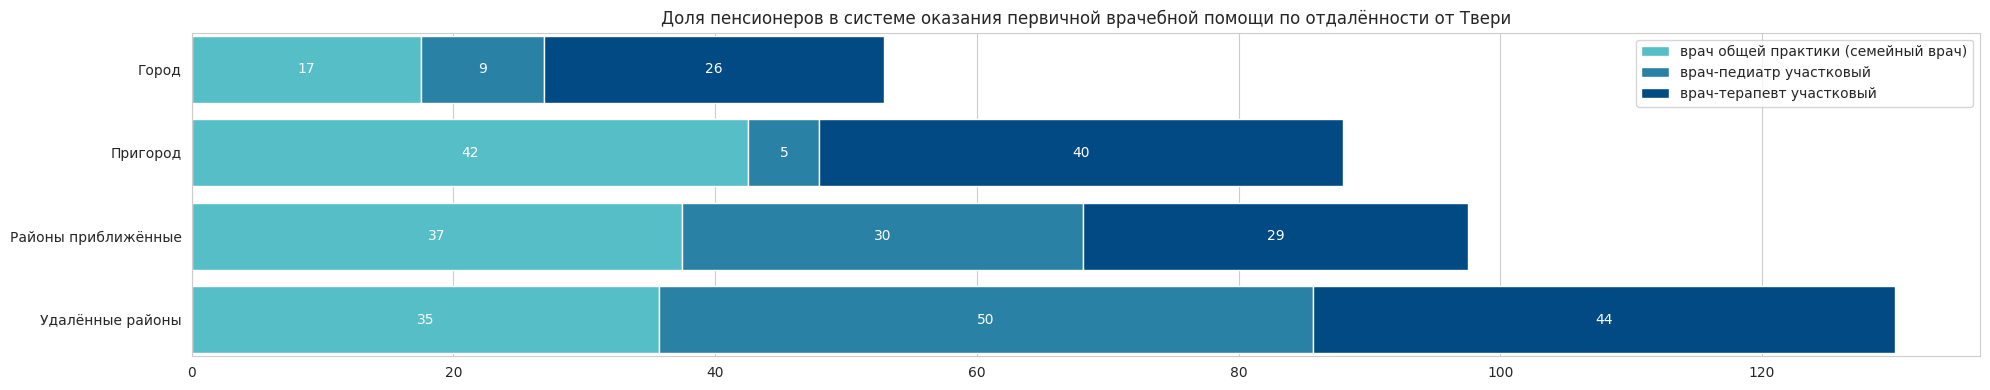

In [57]:
#перечень специализаций первички для values в функцию plot_distribution
primary_professions = ['врач общей практики (семейный врач)','врач-педиатр участковый','врач-терапевт участковый']
#считаем долю пенсионеров в системе оказания первичной врачебной помощи
retirees = (df.query('age_range == "от 60" & profession in @primary_professions')
              .pivot_table(index='location_mo', columns='profession', values='age', aggfunc='count'))
all_doctors = (df.query('profession in @primary_professions')
                 .pivot_table(index='location_mo', columns='profession', values='age', aggfunc='count'))
pensioner_share = round(((retirees / all_doctors) * 100), 2)
#выводим график
plot_distribution((20, 4), 'Доля пенсионеров в системе оказания первичной врачебной помощи по отдалённости от Твери',
                  pensioner_share.index, '', 0, pensioner_share, primary_professions,show_totals=False)

В целом, в городе среди врачей меньше всего пенсионеров. Однако стоит отметить, что в пригороде наименьшая доля пенсионеров наблюдается среди педиатров, в то время как среди врачей общей практики она составляет около 42%.

С удалением от областного центра доля пенсионеров в системе первичной медицинской помощи стабильно растёт, но не превышает 50%. Только в отдалённых от Твери районах пенсионеры составляют ровно половину врачей-педиатров.

## Соотношение полов в системе оказания первичной медицинской помощи
**Женщин в возрасте 60+ работает меньше, чем мужчин в возрасте 60+, а женщин в возрасте 30-50 лет работает больше, чем мужчин этого же возраста?**

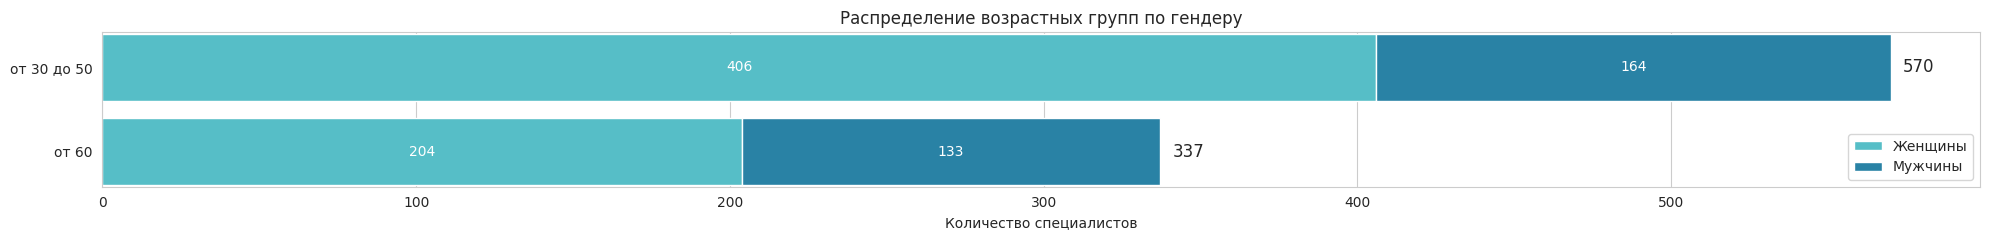

In [58]:
#пересчитаем возрастные группы
def age_range_1(age):
    if age < 30:
        return 'до 30'
    elif 30 <= age <= 50:
        return 'от 30 до 50'
    elif age < 60:
        return 'до 60'
    else:
        return 'от 60'
#применяем функцию
df['age_range_1'] = df['age'].apply(age_range_1)
#собираем сводную для ответа на вопрос
age_staff = df.pivot_table(index='age_range_1', columns='sex', values='age', aggfunc='count').iloc[[2, 3]]
#выводим график
cumulative_barh((20, 2.5), 'Распределение возрастных групп по гендеру',
                age_staff.index, 'Количество специалистов', 4,
                age_staff['Жен.'].fillna(0), 'Женщины',
                age_staff['Муж.'].fillna(0), 'Мужчины')

В целом, среди работающих врачей больше женщин, независимо от возраста. Однако, если рассматривать различные специализации, ситуация может меняться. Например, до разделения по возрастным группам на некоторых должностях было больше мужчин.

Рассмотрим, как изменилась ситуация после проведения этого разделения.

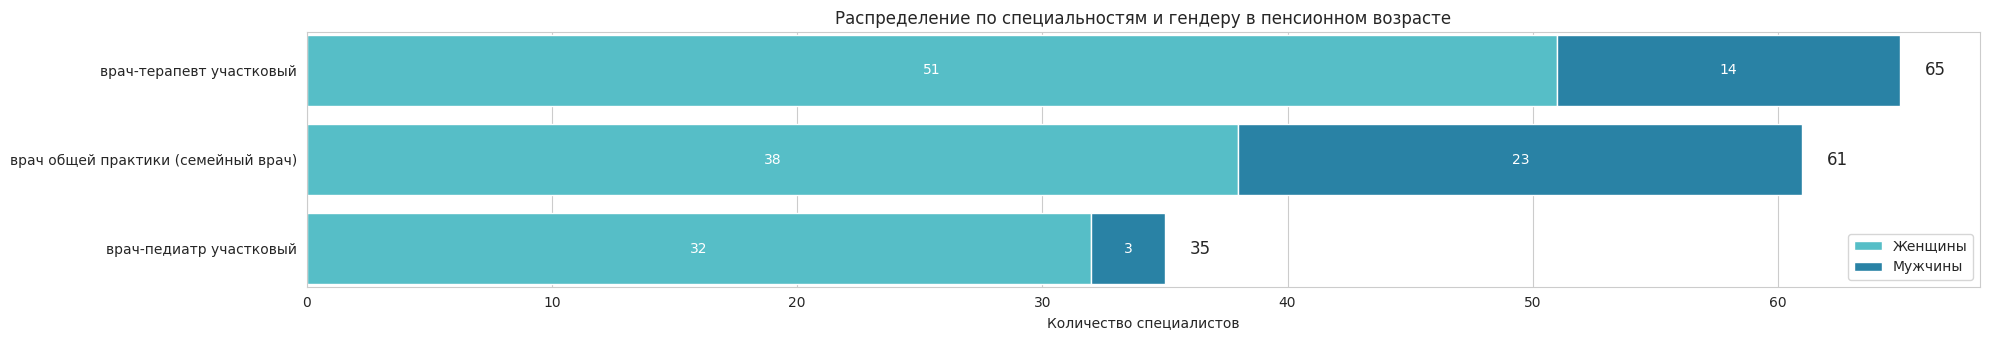

In [59]:
#создаём сводную таблицу по специальностям и полу в возрасте старше 60 лет
profession_60_plus = (df.query('age_range_1 == "от 60"')
                        .pivot_table(index='profession', columns='sex', values='age', aggfunc='count')
                        .assign(total=lambda x: x.sum(axis=1))
                        .sort_values(by='total', ascending=False)).iloc[[0, 1, 5]]
#выводим график
cumulative_barh((20, 3.5), 'Распределение по специальностям и гендеру в пенсионном возрасте',
                profession_60_plus.index, 'Количество специалистов', 1,
                profession_60_plus['Жен.'].fillna(0), 'Женщины',
                profession_60_plus['Муж.'].fillna(0), 'Мужчины')

Наибольшее количество пенсионеров среди терапевтов и врачей общей практики. В этих профессиях по-прежнему преобладает женский пол, однако доля мужчин заметно выросла. А вот среди педиатров доля мужчин уменьшилась с 27% до 8%.

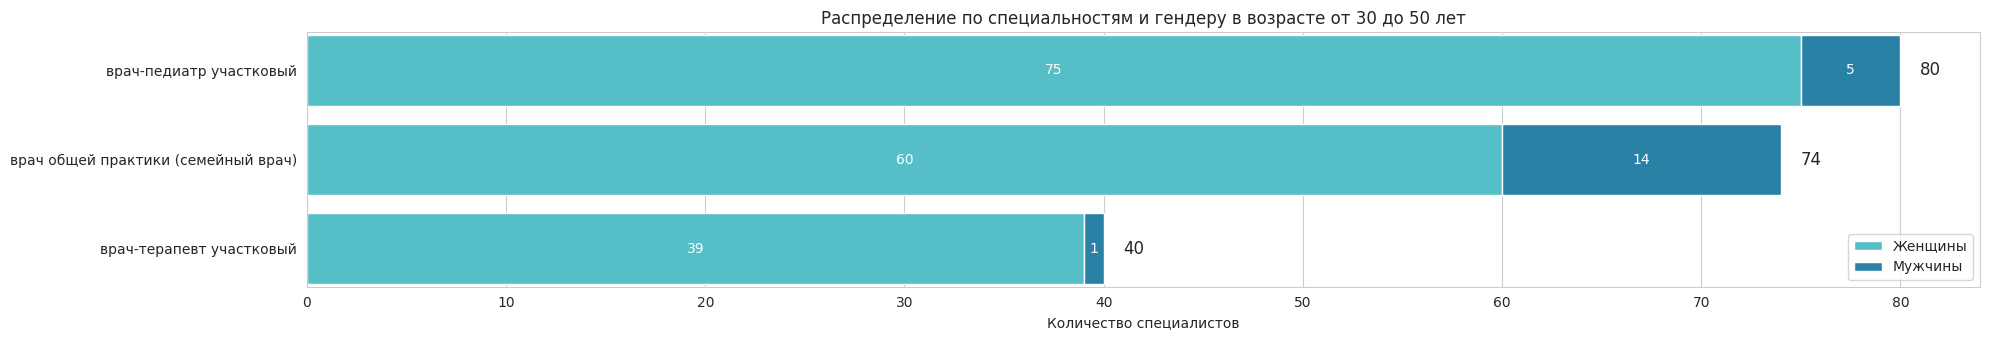

In [60]:
#создаём сводную таблицу по специальностям и полу в возрасте от 30 до 50 лет
profession_30_50 = (df.query('age_range_1 == "от 30 до 50"')
                      .pivot_table(index='profession', columns='sex', values='age', aggfunc='count')
                      .assign(total=lambda x: x.sum(axis=1))
                      .sort_values(by='total', ascending=False)).iloc[[2, 4, 6]]
#выводим график
cumulative_barh((20, 3.5), 'Распределение по специальностям и гендеру в возрасте от 30 до 50 лет',
                profession_30_50.index, 'Количество специалистов', 1,
                profession_30_50['Жен.'].fillna(0), 'Женщины',
                profession_30_50['Муж.'].fillna(0), 'Мужчины')

Среди медицинских работников первичной медико-санитарной помощи в возрасте от 30 до 50 лет преобладают женщины. Среди терапевтов количество мужчин наименьшее.

## Ситуация с молодыми специалистами в Тверской области
**Молодые специалисты (до 35 лет) уезжают в другие регионы и не остаются работать ни в г. Твери, ни в районах Тверской области?**

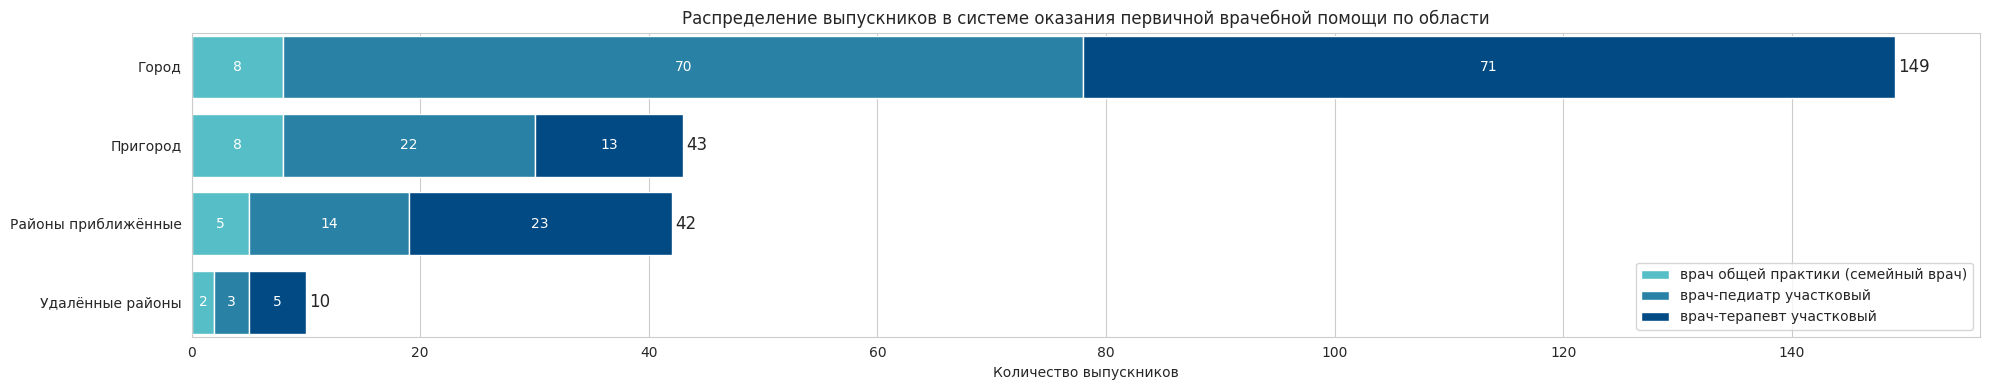

In [61]:
#создаём сводную таблицу по удалённости и специальностям среди молодых специалистов
pivot_35 = (df.query('age <= 35')
            .pivot_table(index='location_mo', columns='profession', values='age', aggfunc='count'))
#выводим график
plot_distribution((20, 4), 'Распределение выпускников в системе оказания первичной врачебной помощи по области',
                  pivot_35.index, 'Количество выпускников', 0.3, pivot_35, primary_professions)

Большинство молодых специалистов работают в городе, а меньше — в отдалённых районах. Многие из них выбрали для себя профессии педиатров и терапевтов.

## Ситуация с выпускниками медицинских универститетов
**Не менее 50 выпускников университета (24-27 лет) устроились работать в этом году в систему оказания первичной врачебной медико-санитарной помощи г. Твери и Тверской области. При этом, в городе Твери выпускников Университета устроилось работать больше, чем в области.**

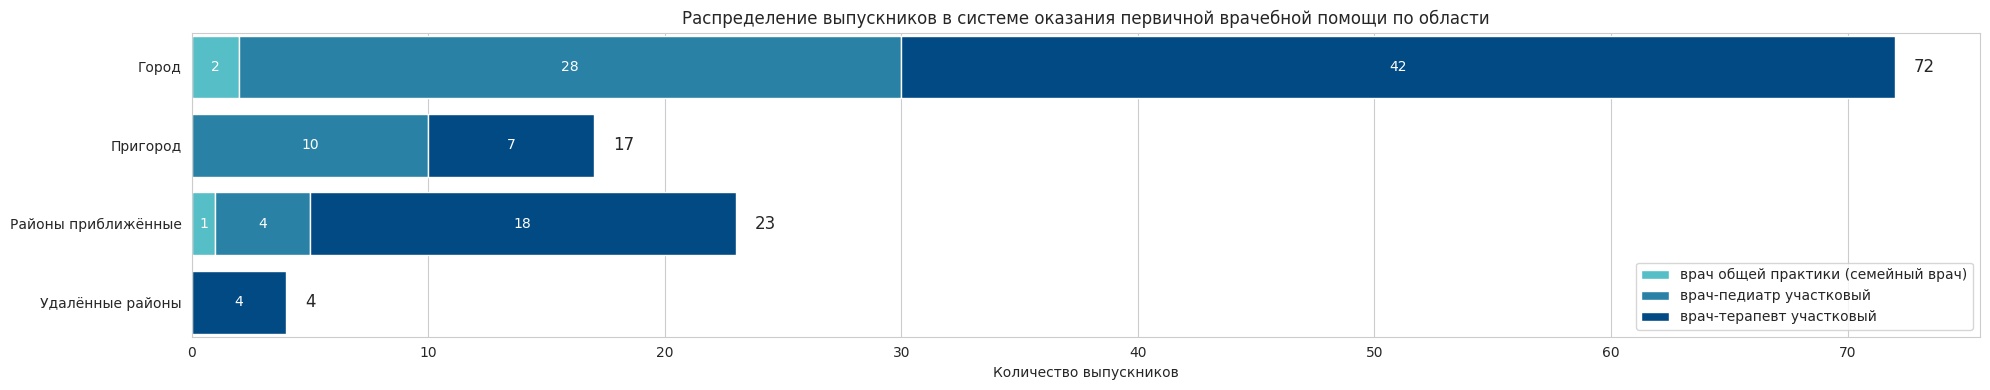

In [62]:
#создаём сводную таблицу по удалённости и специальностям среди выпускников медвузов
pivot_27 = (df.query('age_range == "до 27"')
            .pivot_table(index='location_mo', columns='profession', values='age', aggfunc='count'))
#выводим график
plot_distribution((20, 4), 'Распределение выпускников в системе оказания первичной врачебной помощи по области',
                  pivot_27.index, 'Количество выпускников', 0.8, pivot_27, primary_professions)

В Твери наблюдается значительное количество врачей в возрасте от 24 до 27 лет, что свидетельствует о том, что многие выпускники университета остаются работать в городе. В других районах области доля молодых специалистов значительно ниже, но стоит отметить, что наибольшее количество выпускников работают в качестве терапевтов.

# Общие выводы

Исходя из представленных данных, можно сделать общий вывод о состоянии кадрового обеспечения системы первичной врачебной медико-санитарной помощи в Тверской области:

В Твери наблюдается высокая концентрация медицинских учреждений, что обусловлено более высокими заработными платами и большим количеством молодых специалистов. Однако, несмотря на наличие квалифицированных кадров в областном центре, в отдалённых районах ощущается острая нехватка молодых врачей, а более возрастные специалисты составляют значительную часть персонала. Этот дисбаланс в кадровом составе требует особого внимания.

Частные медицинские организации в основном представлены рентгенолаборантами и врачами-рентгенологами, тогда как государственные учреждения обеспечивают большую долю педиатров и терапевтов. Этот факт подчеркивает различия в кадровом составе в зависимости от типа собственности медицинских учреждений.

Также важным аспектом является соотношение полов среди врачей. В некоторых специальностях, таких как терапия и общая практика, наблюдается значительное преобладание женщин. В то же время мужчины более представлены среди хирургов и реаниматологов. Доля пенсионеров среди медицинских работников растет с удалением от Твери, однако в целом не превышает 50%, что указывает на возможность дальнейшего привлечения молодых специалистов в систему.

Таким образом, для эффективного решения проблемы кадрового голода в первичном звене необходимо сосредоточить усилия на повышении привлекательности работы в отдалённых районах. Это поможет улучшить распределение кадров и обеспечить доступность медицинских услуг для населения.



# [Ссылка на дашборд](https://datalens.yandex/zumuizf7hp46l)